In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import seaborn as sns

import os

from PlottingScripts import CV, Spline, Tune1, distVar, distplot_wratio, StackedHisto, SimpleHisto, mcplot

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Welcome to JupyROOT 6.18/04


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad

def PmuGivenX(mu,x):

    # Returns the probability density value that the true mean is mu given that you
    # have observed x events. Actually employs a series approximation because the real formula
    # involves a very very large numerator and denominator and overflows even high precision
    # variables if your bins contain more than a few hundred events
    # Approximation is good to O(0.1%) or better at all values
    
    pi  = np.pi
    c   = [1.,-1./12,1./288,139./51840,-571./2488320,-163879./209018880]
    
    if x == 0:
        return np.exp(-mu)
    else:
        poly = sum(c[i]/x**(i+0.5) for i in range(len(c)))
        return 1/np.sqrt(2*pi)*np.exp(x+x*np.log(mu/x)-mu)*poly
    
def GetErrorsData(xobs,CL=0.6827):
    step    = 0.01
    upperBoundary = int(max(10,xobs+5*np.sqrt(xobs)))
    r = np.arange(0.01,upperBoundary,step)
    s    = PmuGivenX(r,xobs)*step
    PDF1 = interp1d(r,s,bounds_error=False,fill_value=0)
    PPF1 = interp1d(np.cumsum(s),r)
    xobs_low  = float(PPF1((1-CL)/2))
    xobs_high = float(PPF1(1-(1-CL)/2))
    return xobs_low,xobs_high

In [3]:
def distplot_wratio_complicated(myvar,nbins,myrange,stackedhists,datahist,stxcoord,legpos=0,ymax=-1,normshift=1,fs=(16,11),s_cov=''):

    vals_mc = np.zeros(nbins)
    vals_mc_raw = np.zeros(nbins)
    yerrsq_mc = np.zeros(nbins)
    yrr_mc_sys = np.zeros(nbins)
    ndof = 0

    a_labels_evts = []

    gh_vals,gh_cols,gh_labels,gh_wgts,gh_scale = stackedhists.GetHists(myvar)
    data_vals,_,data_label,data_wgt,data_scale = datahist.GetHist(myvar)

    for i in range(len(gh_vals)):
        h1_raw,_ = np.histogram(gh_vals[i],nbins,range=myrange,weights=gh_wgts[i])     # hist of raw event weights
        h1,_ = np.histogram(gh_vals[i],nbins,range=myrange,weights=gh_wgts[i]*gh_scale[i])

        vals_mc_raw += h1_raw
        vals_mc += h1
    
        scalesort = gh_scale[i].argsort()
        sorted_vals = gh_vals[i][scalesort[::-1]]
        sorted_scale = gh_scale[i][scalesort[::-1]]
        sorted_wgt = gh_wgts[i][scalesort[::-1]]
        for sc in np.unique(sorted_scale):
            subvals = sorted_vals[sorted_scale==sc]
            subwgts = sorted_wgt[sorted_scale==sc]
            subh1,_ = np.histogram(subvals,nbins,range=myrange,weights=subwgts)
            yerrsq_mc += np.power(np.sqrt(subh1)*sc,2)
        
        a_labels_evts.append(gh_labels[i]+' (%.2f)'%h1.sum())

    vals_data_raw,binedges = np.histogram(data_vals,nbins,range=myrange,weights=data_wgt)
    vals_data,_ = np.histogram(data_vals,nbins,range=myrange,weights=np.multiply(data_wgt,data_scale))
    bincenters = np.diff(binedges)/2 + binedges[:-1]    

    #jarretbars
    a_obslo = []
    a_obshi = []
    for i in range(nbins):
        obslo,obshi = GetErrorsData(vals_data[i])
        a_obshi.append(obshi-vals_data[i])
        a_obslo.append(vals_data[i]-obslo)

    m_cov_sys = np.genfromtxt(s_cov,delimiter=',')
    m_cov_detsys = np.genfromtxt('DetSysCov/detsys_%s_cov.csv'%myvar,delimiter=',')
    
    #detsys is fractional, so we multiply it by MC
    for i in range(nbins):
        for j in range(nbins):
            if(vals_mc[i] > 0 and vals_mc[j] > 0):
                m_cov_detsys[i][j] *= vals_data[i]*vals_data[j]
            else:
                m_cov_detsys[i][j] = 0
    
    m_cov = m_cov_detsys+m_cov_sys
        
    yerr_mc_sys = np.sqrt(np.diag(m_cov))
    yerr_mc_total = np.sqrt(np.diag(m_cov) + yerrsq_mc)

    yerrsq_data = np.zeros(nbins)
    for i in range(nbins):
        if vals_mc_raw[i] > 0:
            ndof += 1
            if vals_data[i] > 0:
                yerrsq_data[i] += (3.0*vals_data[i]*vals_mc[i]*normshift)/(vals_mc[i]*normshift+2.0*vals_data[i])
            else:
                yerrsq_data[i] += vals_mc[i]*normshift/2.0
            m_cov[i][i] += yerrsq_data[i]
        else:
            m_cov[i][i] += 999

    yerr_data = np.sqrt(yerrsq_data)

    er_rat_line = np.zeros(nbins)
    er_rat_line_sys = np.zeros(nbins)
    er_rat_dotshi = np.zeros(nbins)
    er_rat_dotslo = np.zeros(nbins)

    for i in range(nbins):
        if vals_mc[i] > 0:
            er_rat_line[i] = yerr_mc_total[i]/float(vals_mc[i])
            er_rat_line_sys[i] = yerr_mc_sys[i]/float(vals_mc[i])
            er_rat_dotshi[i] = a_obshi[i]/float(vals_mc[i])
            er_rat_dotslo[i] = a_obslo[i]/float(vals_mc[i])
    
    chisq = 0.0
    invcov = np.linalg.inv(m_cov)
    # calc chi2
    for i in range(nbins):
        for j in range(nbins):
            if vals_mc_raw[i] > 0 and vals_mc_raw[j] > 0:
                chisq += (vals_mc[i] - vals_data[i]) * (vals_mc[j] - vals_data[j]) * invcov[i][j]
    pval = 1 - stats.chi2.cdf(chisq, ndof)
    print(chisq/float(ndof),pval)
    
    fig,ax = plt.subplots(figsize=fs)
    fig.patch.set_alpha(1)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, .75])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ymax = max(vals_data.max(),vals_mc.max())*1.35

    ax0.set_ylim(0,ymax)
    ax0.set_xlim(myrange)
    ax1.set_ylim(.5,1.5)
    ax1.set_xlim(myrange)
    ax1.set_xlabel(stxcoord,fontsize=20)
    ax0.set_ylabel('Events in 5e19 POT',fontsize=20)
    ax1.set_ylabel('Data/MC',fontsize=20)
    ax0.set_title('MCC9 Data/MC',fontsize=30)

    ax0.hist(gh_vals,nbins,range=myrange,weights=[gh_wgts[i]*gh_scale[i] for i in range(len(gh_wgts))],color=gh_cols,stacked=True,linewidth=0,label=a_labels_evts,edgecolor=None)
    ax0.errorbar(bincenters,vals_data,fmt='.',yerr=(a_obslo,a_obshi),color='black',capsize=5,label=data_label+' (%i)'%vals_data.sum())

    errboxes = []
    for i in range(len(bincenters)):
        rect = Rectangle((binedges[i],(vals_mc[i]-yerr_mc_sys[i])),binedges[i+1]-binedges[i],yerr_mc_sys[i]*2)
        errboxes.append(rect)
    pc = PatchCollection(errboxes,facecolor=None,alpha=.1,hatch='/',zorder=12)
    ax0.add_collection(pc)
    ax0.hist(np.zeros(1),(1,2),facecolor=None,alpha=.1,hatch='//',zorder=0,label='Systematics')
    ax0.legend(loc='upper right',fontsize=15,frameon=False,ncol=3)

    errboxes_tot = []
    errboxes_sys = []
    for i in range(len(er_rat_dotshi)):
        rect_tot = Rectangle((binedges[i],1-er_rat_line[i]),binedges[i+1]-binedges[i],er_rat_line[i]*2)
        errboxes_tot.append(rect_tot)
        rect_sys = Rectangle((binedges[i],1-er_rat_line_sys[i]),binedges[i+1]-binedges[i],er_rat_line_sys[i]*2)
        errboxes_sys.append(rect_sys)

    pc_tot = PatchCollection(errboxes_tot, facecolor='red', alpha=.3)
    pc_sys = PatchCollection(errboxes_sys, facecolor=None, alpha=.1,hatch='/',zorder=12)
    ax1.add_collection(pc_tot)
    ax1.add_collection(pc_sys)
    ax1.hist(np.zeros(1),(1,2),facecolor=None,alpha=.1,hatch='//',zorder=0,label='Sys Error')
   
    ax1.hist(np.zeros(1),(1,2),facecolor='red',alpha=.3,zorder=0,label='Total Error')
    ax1.errorbar(bincenters,np.true_divide(vals_data,vals_mc),yerr=(er_rat_dotshi,er_rat_dotslo),fmt='o',color='maroon',capsize=0)

    ax1.legend(loc='lower right',fontsize=15,frameon=False)


    ax1.axhline(1,color='black',linestyle=':')
    ax0.annotate(r'$\sum$data/$\sum$MC = %.2f'%(vals_data.sum()/float(vals_mc.sum())),xy=(.01,.92),xycoords='axes fraction',fontsize=20,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))

    ax1.annotate('p-value: %.3f\n'%pval+r'$\chi^2_{CNP}/%i  (dof)$: %.3f'%(ndof,chisq/float(ndof)),xy=(.85,.7), xycoords='axes fraction',fontsize=15,bbox=dict(boxstyle="round4", fc="w",alpha=.9))

    plt.tight_layout()
    
    
    #X, Y = np.meshgrid(binedges,binedges)
    #fig2,ax2 = plt.subplots(figsize=(10,10))
    #crat = ax2.pcolormesh(X, Y,m_cov_detsys,cmap='cool')#,vmin=-2,vmax=3)
    #cbar = fig2.colorbar(crat)
    
    return fig,ax0,pval


## Set scalings

In [4]:
#wc tagger
NUMU_RUN1_POT = 4.71579e+20
NUMU_LOWE_RUN1_POT = 1.63103516179e+21
NUE_RUN1_POT  = 9.80259e+22
RUN1_POT = 4.403e+19   #  run1
EXTRUN1_POT = (22474918.0) / float ( 9776965.0) * RUN1_POT #run1
DIRT_RUN1_POT = 2.61947e+20

NUMU_RUN3_POT = 8.98773223801e+20
NUMU_LOWE_RUN3_POT = 1.51234621011e+21
NUE_RUN3_POT = 4.70704675581e+22
RUN3_POT = 8.786e+18 # no beam quality  cut
#RUN3_POT = 1.701e+20 #1.5e20
EXTRUN3_POT = (39566274.0) / float (2263559) * RUN3_POT
#EXTRUN3_POT = (39566274.0) / float (43980680.0) * RUN3_POT


POT_SCALE_FACTOR = RUN1_POT
NUMU_RUN1_SCALE = POT_SCALE_FACTOR / float(NUMU_RUN1_POT)
NUMU_LOWE_RUN1_SCALE = POT_SCALE_FACTOR / float(NUMU_LOWE_RUN1_POT)
NUMU_RUN3_SCALE = POT_SCALE_FACTOR / float(NUMU_RUN3_POT)
NUMU_LOWE_RUN3_SCALE = POT_SCALE_FACTOR / float(NUMU_LOWE_RUN3_POT)
NUE_RUN1_SCALE = POT_SCALE_FACTOR / float(NUE_RUN1_POT)
NUE_RUN3_SCALE = POT_SCALE_FACTOR / float(NUE_RUN3_POT)
EXT_RUN1_SCALE = POT_SCALE_FACTOR / float(EXTRUN1_POT)
EXT_RUN3_SCALE = POT_SCALE_FACTOR / float(EXTRUN3_POT)
DIRT_RUN1_SCALE = POT_SCALE_FACTOR / float(DIRT_RUN1_POT)


RUN1_SCALE = POT_SCALE_FACTOR / float(RUN1_POT)
RUN3_SCALE = POT_SCALE_FACTOR / float(RUN3_POT)

print(RUN3_POT)

8.786e+18


## Load up parquets with our samples and apply precuts

In [5]:
tag = 'May1'
datafolder = '../../data'

orthogonalcut = 'MaxShrFrac < .2'
precuts ='ChargeNearTrunk > 0 and FailedBoost != 1 and OpenAng > .5'# and  and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15'
emptycut = 'Enu_1m1p > 0'

precut = orthogonalcut + ' and ' + precuts


df_numu_run1_presel = pd.read_parquet('%s/pickles/numu_run1_nodupes%s.parquet'%(datafolder,tag)).query(precut)
df_numu_run1_presel_lowe = pd.read_parquet('%s/pickles/numu_lowe_run1_nodupes%s.parquet'%(datafolder,tag)).query(precut)

df_numu_run3_presel = pd.read_parquet('%s/pickles/numu_run3_nodupes%s.parquet'%(datafolder,tag)).query(precut)
df_numu_run3_presel_lowe = pd.read_parquet('%s/pickles/numu_lowe_run3_nodupes%s.parquet'%(datafolder,tag)).query(precut)

df_nue_run1_presel = pd.read_parquet('%s/pickles/nue_run1_nodupes%s.parquet'%(datafolder,tag)).query(precut)
df_nue_run3_presel = pd.read_parquet('%s/pickles/nue_run3_nodupes%s.parquet'%(datafolder,tag)).query(precut)

df_ext_run1_presel = pd.read_parquet('%s/pickles/ext_run1_nodupes%s.parquet'%(datafolder,tag)).query(precut)
df_ext_run3_presel = pd.read_parquet('%s/pickles/ext_run3_nodupes%s.parquet'%(datafolder,tag)).query(precut)

df_data_run1_presel = pd.read_parquet('%s/pickles/data_run1_nodupes%s.parquet'%(datafolder,tag)).query(precut)
df_data_run3_presel = pd.read_parquet('%s/pickles/data_run3_nodupes%s.parquet'%(datafolder,tag)).query(precut)

#df_data_run3_presel = pd.read_parquet('%s/pickles/data_run3_filter_nodupes%s.parquet'%(datafolder,tag)).query(precut)

df_dirt_run1_presel = pd.read_parquet('%s/pickles/dirt_run1_nodupes%s.parquet'%(datafolder,tag)).query(precut)

In [6]:
alldfs = [df_numu_run1_presel,df_numu_run1_presel_lowe,df_numu_run3_presel,df_numu_run3_presel_lowe,df_nue_run1_presel,df_nue_run3_presel,df_ext_run1_presel,df_ext_run3_presel,df_data_run1_presel,df_data_run3_presel,df_dirt_run1_presel]

In [42]:
#add experimental weights

with open('/home/dcianci/Physics/1e1p/1mu1pSelection/bdtweights_1m1p_run1_lowe_may13vars.pickle','rb') as handle: bdt_run1_cosmic,bdt_run1_nu = pickle.load(handle)          # Load BDT weights for 1mu1p background differentiation
with open('/home/dcianci/Physics/1e1p/1mu1pSelection/bdtweights_1m1p_run3_lowe_may13vars.pickle','rb') as handle: bdt_run3_cosmic,bdt_run3_nu = pickle.load(handle)          # Load BDT weights for 1mu1p background differentiation  

vars_may13 = ['OpenAng','Phis','ChargeNearTrunk','Enu_1m1p','PhiT_1m1p','AlphaT_1m1p','PT_1m1p','PTRat_1m1p','BjX_1m1p','BjY_1m1p','Sph_1m1p','Q0_1m1p','Q3_1m1p','Lepton_PhiReco','Lepton_TrackLength','Proton_PhiReco','Proton_ThetaReco']

myvars = vars_may13



In [43]:
for df in alldfs:
    df.insert(0,'bdt_run1_cosmic',bdt_run1_cosmic.predict_proba(df[myvars].values.tolist())[:,0])
    df.insert(0,'bdt_run1_nu',bdt_run1_nu.predict_proba(df[myvars].values.tolist())[:,0])
    df.insert(0,'bdt_run3_cosmic',bdt_run3_cosmic.predict_proba(df[myvars].values.tolist())[:,0])
    df.insert(0,'bdt_run3_nu',bdt_run3_nu.predict_proba(df[myvars].values.tolist())[:,0])
    
    #df.insert(0,'bdt_run1_hiE',bdt_run1_hiE.predict_proba(df[myvars].values.tolist())[:,0])
    
    df.insert(0,'Lepton_CosTheta',np.cos(df['Lepton_ThetaReco'].values).tolist())
    df.insert(0,'Proton_CosTheta',np.cos(df['Proton_ThetaReco'].values).tolist())
    
    print('one down')


one down
one down
one down
one down
one down
one down
one down
one down
one down
one down
one down


## Define our histogram stacks

In [44]:
run1Hists = StackedHisto((df_numu_run1_presel.query('MC_energyInit > 400'),df_numu_run1_presel_lowe,df_nue_run1_presel),(NUMU_RUN1_SCALE,NUMU_LOWE_RUN1_SCALE,NUE_RUN1_SCALE))
#run1Hists = StackedHisto((df_numu_run1_presel,df_nue_run1_presel),(NUMU_RUN1_SCALE,NUE_RUN1_SCALE))
run1Hists.AddStrata("mc_label in ['numu_CCQE']",r'BNB $\nu_\mu$ CCQE','blue')
run1Hists.AddStrata("mc_label in ['numu_MEC']",r'BNB $\nu_\mu$ MEC','cyan')
run1Hists.AddStrata("mc_label in ['numu_piplusminus']",r'BNB $\nu_\mu$ Res $\pi^{+/-}$','darkgreen')
run1Hists.AddStrata("mc_label in ['numu_pizero']",r'BNB $\nu_\mu$ Res $\pi^{0}$','greenyellow')
run1Hists.AddStrata("mc_label in ['nue_CCQE']",r'$\nu_e$ Intrinsic','pink')
run1Hists.AddStrata("mc_label in ['numu_other','BNB nue_other','nue_MEC','nue_piplusminus','nue_pizero']",r'BNB Other','gold')
run1Hists.AddStrata("mc_label in ['badreco']",r'BNB Bad Reco','coral')
run1Hists.AddStrata("mc_label in ['offvtx']",r'BNB 1L1P Off Vertex','grey')
run1Hists.AddStrata("mc_label in ['nLmP']",r'BNB Not 1L1P','crimson')
run1Hists.AddLayer(df_dirt_run1_presel,DIRT_RUN1_SCALE,1,'Dirt','peru')
run1Hists.AddLayer(df_ext_run1_presel,EXT_RUN1_SCALE,0,'Cosmic Background','fuchsia')

run1DataHist = SimpleHisto(df_data_run1_presel,RUN1_SCALE,0,'','bnb5e19 [Run 1]')
#fakeDataHist = SimpleHisto(df_fakedata_presel,1,0,'','Fakedata')


run3Hists = StackedHisto((df_numu_run3_presel.query('MC_energyInit > 400'),df_numu_run3_presel_lowe,df_nue_run3_presel),(NUMU_RUN3_SCALE,NUMU_LOWE_RUN3_SCALE,NUE_RUN3_SCALE))
run3Hists.AddStrata("mc_label in ['numu_CCQE']",r'BNB $\nu_\mu$ CCQE','blue')
run3Hists.AddStrata("mc_label in ['numu_MEC']",r'BNB $\nu_\mu$ MEC','cyan')
run3Hists.AddStrata("mc_label in ['numu_piplusminus']",r'BNB $\nu_\mu$ Res $\pi^{+/-}$','darkgreen')
run3Hists.AddStrata("mc_label in ['numu_pizero']",r'BNB $\nu_\mu$ Res $\pi^{0}$','greenyellow')
run3Hists.AddStrata("mc_label in ['nue_CCQE']",r'$\nu_e$ Intrinsic','pink')
run3Hists.AddStrata("mc_label in ['numu_other','BNB nue_other','nue_MEC','nue_piplusminus','nue_pizero']",r'BNB Other','gold')
run3Hists.AddStrata("mc_label in ['badreco']",r'BNB Bad Reco','coral')
run3Hists.AddStrata("mc_label in ['offvtx']",r'BNB 1L1P Off Vertex','grey')
run3Hists.AddStrata("mc_label in ['nLmP']",r'BNB Not 1L1P','crimson')
run3Hists.AddLayer(df_dirt_run1_presel,DIRT_RUN1_SCALE,1,'Dirt','peru')
run3Hists.AddLayer(df_ext_run3_presel,EXT_RUN3_SCALE,0,'Cosmic Background','fuchsia')
#run3Hists.AddLayer(df_numu_run1_presel_lowe,NUMU_LOWE_RUN3_SCALE,1,'Low E Patch','deepskyblue')

run3DataHist = SimpleHisto(df_data_run3_presel,RUN3_SCALE,0,'','bnb1e19 [Run 3]')

In [45]:
nbins = 36
s_annotation = 'All Precuts, Orthogonality Cuts\nand No Duplicate Vertices'

Events: 4071.0
MC: 4186.080631802797
Min Bin ct (data): 0.0


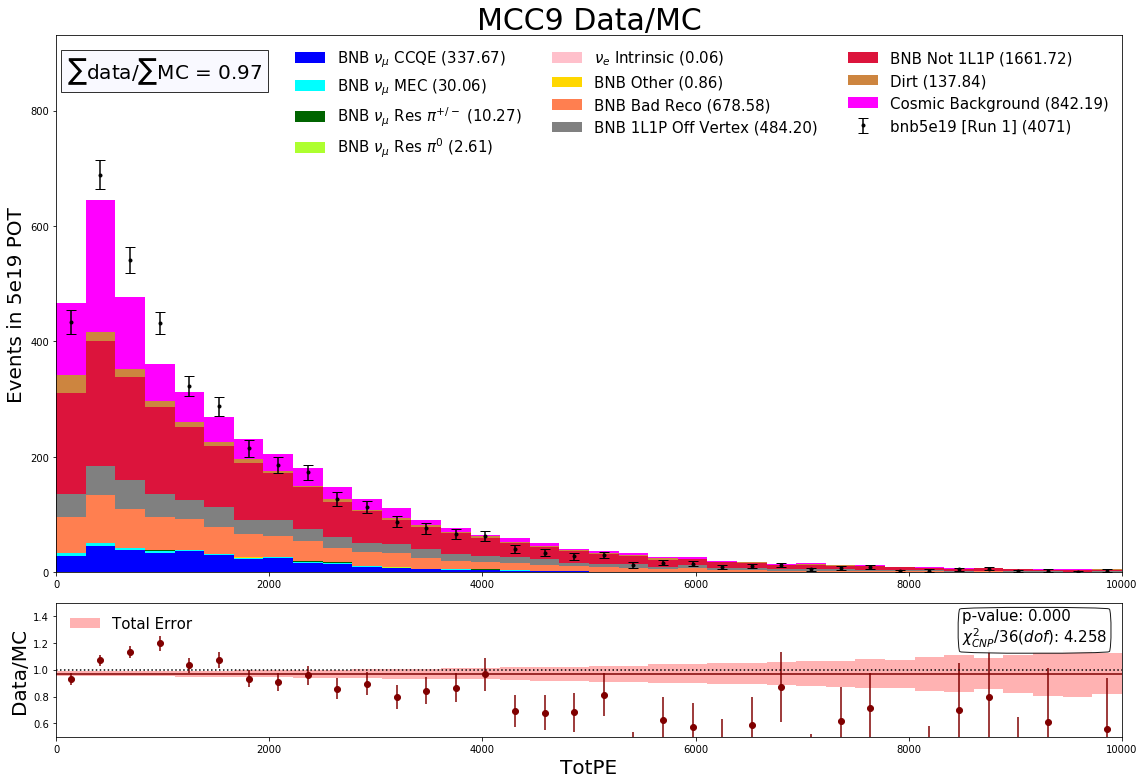

In [46]:
# distplot_wratio(string of variable name, number of bins, range, stacked histo list, data list, name for x-axis)
# for other arguments, see PlottingScripts.py

vartest = 'TotPE'
varname = vartest#r'Reconstructed $E_\nu$'
myrange = (0,10000)

fig,ax0,_ = distplot_wratio(vartest,nbins,myrange,run1Hists,run1DataHist,varname,normshift=.97)
#ax0.annotate(s_annotation,xy=(.75,.6), xycoords='axes fraction',fontsize=15)
#ax0.annotate('No Low E Patch',xy=(.75,.5), xycoords='axes fraction',fontsize=20)
#ax0.set_ylabel('Events in 1e19',fontsize=25)

MC raw 52009.1574259974
Data raw 4085.0


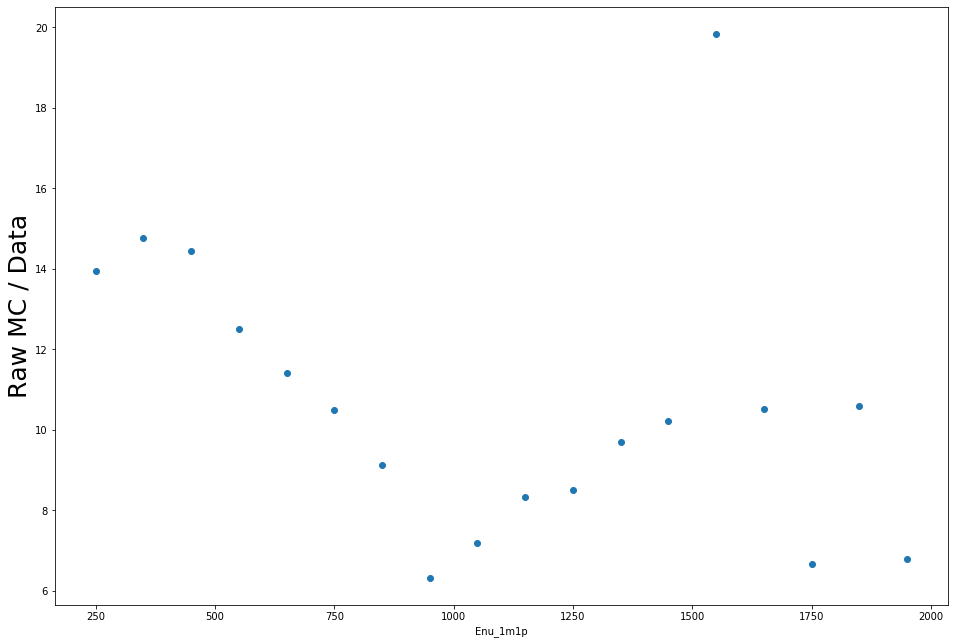

In [12]:
# Test for MC Stats!
vartest = 'Enu_1m1p'
myrange = (200,2000)
mybins = 18




def mcplot(_vartest,_myrange,_mybins,_predhists,_obshist):
    _pvals,_,_,_pwgts,_ = _predhists.GetHists(_vartest)
    _ovals,_,_,_owgts,_ = _obshist.GetHist(_vartest)

    phist = np.zeros(_mybins)
    for i in range(len(_pvals)):
        _ph,_ = np.histogram(_pvals[i],bins=_mybins,range=_myrange,weights=_pwgts[i])
        phist += _ph

    ohist,binedges = np.histogram(_ovals,bins=_mybins,range=_myrange,weights=_owgts)
    bincenters = np.diff(binedges)/2 + binedges[:-1]

    fig,ax = plt.subplots(figsize=(16,11))
    plt.scatter(bincenters,np.true_divide(phist,ohist,where=ohist!=0))
    ax.set_ylabel('Raw MC / Data',fontsize=25)
    ax.set_xlabel(_vartest)
    print('MC raw',phist.sum())
    print('Data raw',ohist.sum())

mcplot(vartest,myrange,mybins,run1Hists,run1DataHist)

In [13]:
# Make big list of variables with their accompanying ranges so we can just dump a buttload of plots
varlist = []

varlist.append(distVar('Xreco',(15,241.25),'Reco Vertex X','../data/CovMatrices_Apr20/covar_postsel__x_reco.txt'))
varlist.append(distVar('Yreco',(-101.5,101.5),'Reco Vertex Y','../data/CovMatrices_Apr20/covar_postsel__y_reco.txt'))
varlist.append(distVar('Zreco',(15,1021.8),'Reco Vertex Z','../data/CovMatrices_Apr20/covar_postsel__z_reco.txt'))
varlist.append(distVar('OpenAng',(.5,np.pi),'Opening Angle (rads)','../data/CovMatrices_Apr20/covar_postsel__openang_reco.txt'))
varlist.append(distVar('Thetas',(0,2*np.pi),r'Sum of Thetas ($\theta_{p} + \theta_{\mu}$) (rads)','../data/CovMatrices_Apr20/covar_postsel__sum_thetas_reco.txt'))
varlist.append(distVar('Phis',(0,2*np.pi),r'Sum of Phis ($\phi_{p} + \phi_{\mu}$)  (rads)','../data/CovMatrices_Apr20/covar_postsel__sum_phis_reco.txt'))
varlist.append(distVar('ChargeNearTrunk',(0,800),'ADC Charge within 5cm of Reco Vertex','../data/CovMatrices_Apr20/covar_postsel__charge_near_trunk_reco.txt'))
#varlist.append(distVar('CCQEEnergyShift_1m1p',(0,5),'Energy Shift (in MeV) to Maximize QE Consistency'))
varlist.append(distVar('Enu_1m1p',(200,2000),'Reconstructed Neutrino Energy (MeV)','../data/CovMatrices_Apr20/covar_postsel__nu_energy_reco.txt'))
varlist.append(distVar('PhiT_1m1p',(0,np.pi),r'$\phi_T$','../data/CovMatrices_Apr20/covar_postsel__phiT_reco.txt'))
varlist.append(distVar('AlphaT_1m1p',(0,np.pi),r'$\alpha_T$','../data/CovMatrices_Apr20/covar_postsel__alphaT_reco.txt'))
varlist.append(distVar('PT_1m1p',(0,850),r'$p_T$','../data/CovMatrices_Apr20/covar_postsel__pT_reco.txt'))
varlist.append(distVar('PTRat_1m1p',(0,1),r'$p_T/|p|$','../data/CovMatrices_Apr20/covar_postsel__pT_ratio_reco.txt'))
varlist.append(distVar('BjX_1m1p',(0,2),'Bjorken X','../data/CovMatrices_Apr20/covar_postsel__Bjx_reco.txt'))
varlist.append(distVar('BjY_1m1p',(0,1),'Bjorken Y','../data/CovMatrices_Apr20/covar_postsel__Bjy_reco.txt'))
varlist.append(distVar('Q2_1m1p',(0,6e5),r'$Q^2$','../data/CovMatrices_Apr20/covar_postsel__Q2_reco.txt'))
varlist.append(distVar('Sph_1m1p',(0,4000),'QE Consistency','../data/CovMatrices_Apr20/covar_postsel__sph_reco.txt'))
varlist.append(distVar('PzEnu_1m1p',(-1500,400),r'$p_z - E_\nu$ (MeV)'))
varlist.append(distVar('Q0_1m1p',(70,600),r'$Q_0$','../data/CovMatrices_Apr20/covar_postsel__Q0_reco.txt'))
varlist.append(distVar('Q3_1m1p',(50,1000),r'$Q_3$','../data/CovMatrices_Apr20/covar_postsel__Q3_reco.txt'))
varlist.append(distVar('Lepton_PhiReco',(-np.pi,np.pi),r'Muon $\phi$','../data/CovMatrices_Apr20/covar_postsel__lepton_phi_reco.txt'))
varlist.append(distVar('Lepton_ThetaReco',(0,np.pi),r'Muon $\theta$','../data/CovMatrices_Apr20/covar_postsel__lepton_theta_reco.txt'))
varlist.append(distVar('Lepton_TrackLength',(5,200),'Muon Track Length (cm)','../data/CovMatrices_Apr20/covar_postsel__lepton_length_reco.txt'))
varlist.append(distVar('Muon_Edep',(20,600),'Reco Muon Energy (from range) (MeV)','../data/CovMatrices_Apr20/covar_postsel__lepton_KE_reco.txt'))
varlist.append(distVar('Proton_PhiReco',(-np.pi,np.pi),r'Proton $\phi$','../data/CovMatrices_Apr20/covar_postsel__proton_phi_reco.txt'))
varlist.append(distVar('Proton_ThetaReco',(0,np.pi),r'Proton $\theta$','../data/CovMatrices_Apr20/covar_postsel__proton_theta_reco.txt'))
varlist.append(distVar('Proton_TrackLength',(5,150),'Proton Track Length','../data/CovMatrices_Apr20/covar_postsel__proton_length_reco.txt'))
varlist.append(distVar('Proton_Edep',(50,500),'Reco Proton Energy (from range) (MeV)','../data/CovMatrices_Apr20/covar_postsel__proton_KE_reco.txt'))

varlist.append(distVar('Proton_CosTheta',(-1,1),'Proton Cos Theta'))
varlist.append(distVar('Lepton_CosTheta',(-1,1),'Muon Cos Theta'))




Events: 3938.0
Min Bin ct (data): 43.0
Events: 3921.0
Min Bin ct (data): 69.0
Events: 4064.0
Min Bin ct (data): 46.0
Events: 4089.0
Min Bin ct (data): 11.0


/home/dcianci/Physics/1e1p/1L1PSelection/PlottingScripts.py:310: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(bincenters,np.true_divide(vals_data,vals_mc),yerr=er_rat_dots,fmt='o',color='maroon',capsize=0)


Events: 4089.0
Min Bin ct (data): 0.0


KeyboardInterrupt: 

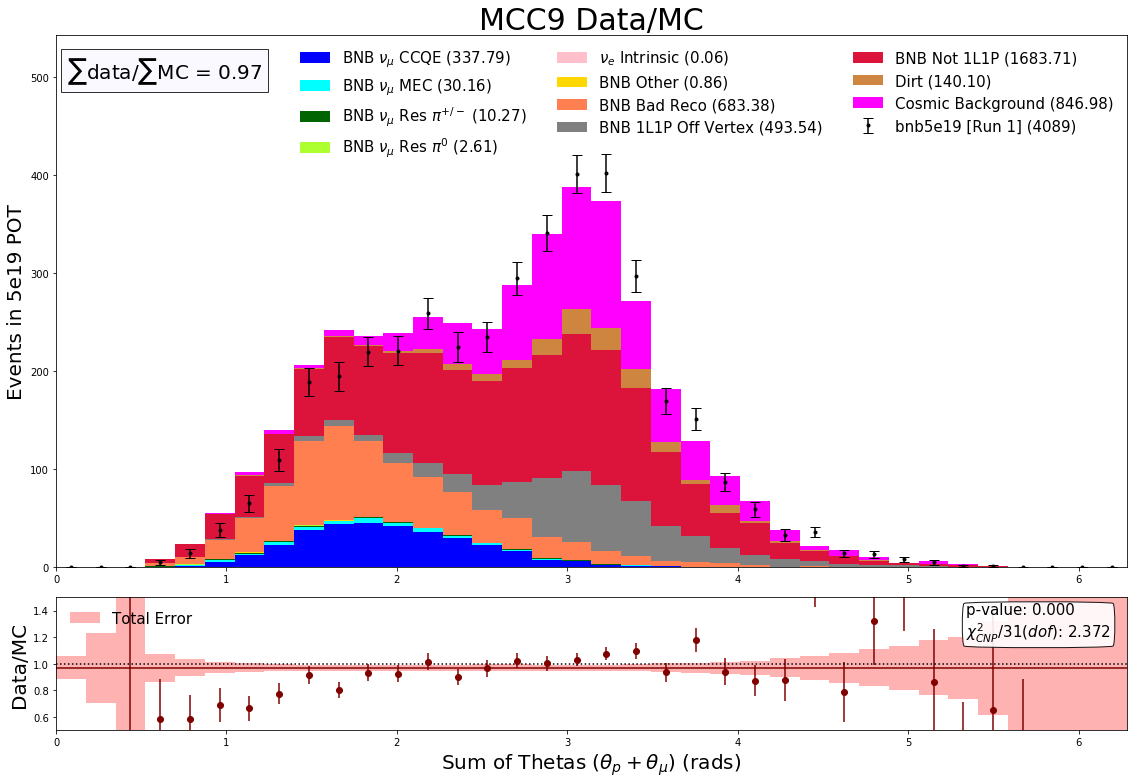

In [14]:
dumpbins = 36
dumphole = '/home/dcianci/Downloads/May20_InternalNote_1m1p_presel' # where are we dumping these?

if not os.path.exists(dumphole):
    os.makedirs(dumphole)

a_pval = []
a_varname = []

    
    
for dist in varlist:
    fig,ax0,pval = distplot_wratio(dist.myname,dumpbins,dist.myrange,run1Hists,run1DataHist,dist.mylabel,normshift=.97)
    #ax0.set_ylabel('Events in 4e17',fontsize=25)
    plt.savefig(dumphole+'/'+dist.myname+'.png')
    plt.close(fig)
    a_pval.append(pval)
    a_varname.append(dist.myname)

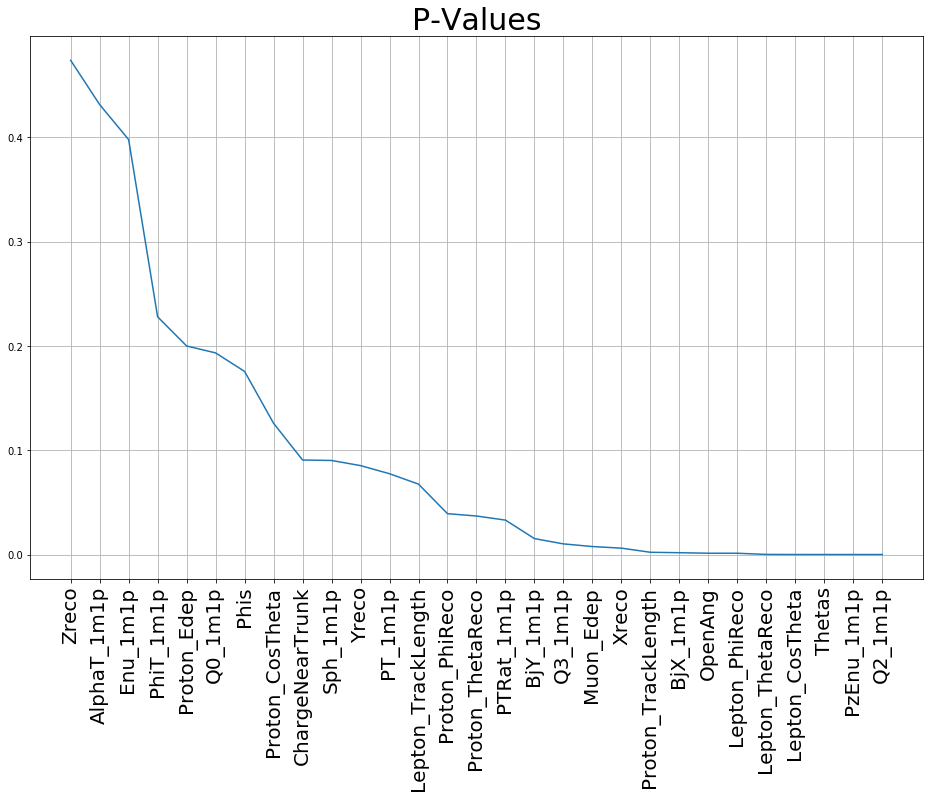

In [17]:
psort = np.array(a_pval).argsort()
sorted_pval = np.array(a_pval)[psort[::-1]]
sorted_varname = np.array(a_varname)[psort[::-1]]
    
fig,ax = plt.subplots(figsize=(16,10))
ax.set_title('P-Values',fontsize=30)
plt.plot(range(len(varlist)), sorted_pval)
plt.xticks(range(len(varlist)),sorted_varname, rotation='vertical',fontsize=20)
plt.grid(True)
plt.savefig(dumphole+'/pvals.png')

# Apply cuts

In [47]:
#bdtcuts = 'BDTscore_1mu1p_cosmic > 0 and BDTscore_1mu1p_nu > 0'
#bdtcuts = 'abs(bdt_score_cosmic_13-bdt_score_nu_13) < .05'
bdtcuts = 'bdt_run1_cosmic < .5 and bdt_run1_nu < .5'

emptycut = 'Enu_1m1p > 0'
morecuts = 'Enu_1m1p < 1000'#Lepton_CosTheta < .9'

s_cuts = bdtcuts + ' and ' + morecuts
 
s_ano_simple_w = wrap('Precuts and '+s_cuts,28)
s_ano_simple = '' 
for ln in s_ano_simple_w:
    s_ano_simple += ln + '\n'

In [48]:
run1Hists.AddCut(s_cuts)
run3Hists.AddCut(s_cuts)
run1DataHist.AddCut(s_cuts)
run3DataHist.AddCut(s_cuts)
  
errlabel = 'Flux Sys Only'
nbins = 18

Events: 231.0
MC: 244.205926486328
Min Bin ct (data): 0.0


Text(120.25, 0.5, 'Events in 1.5e20 POT')

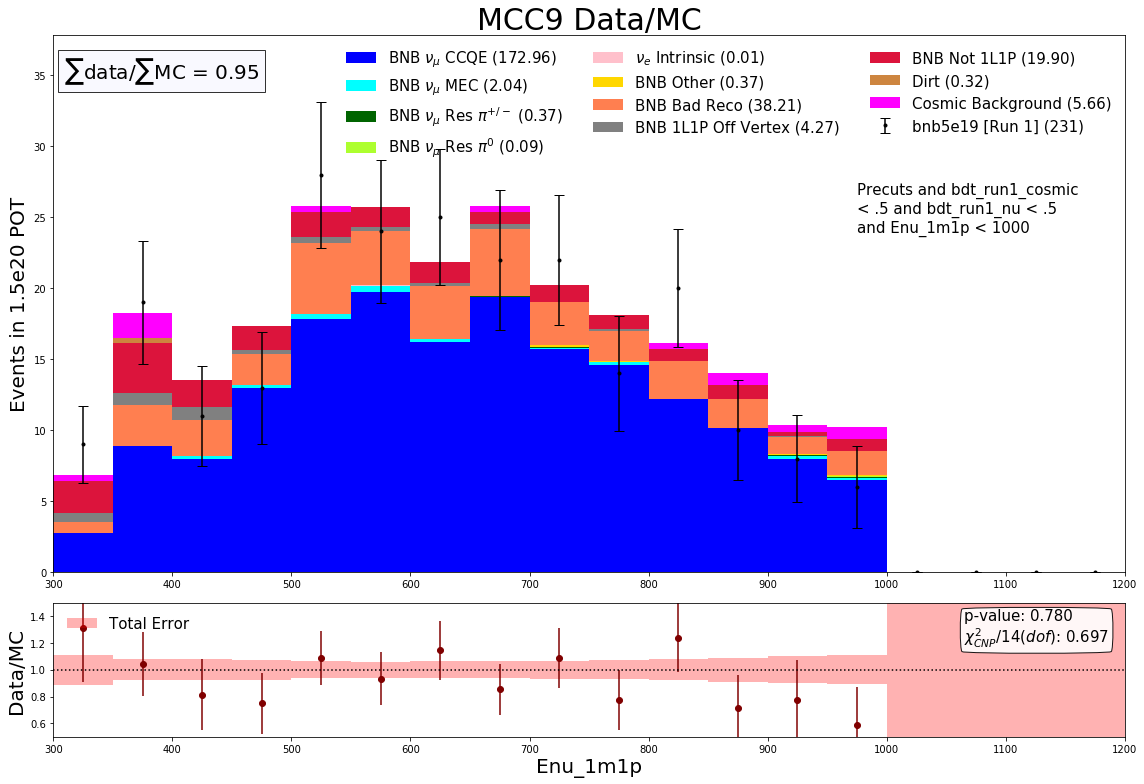

In [51]:
vartest = 'Enu_1m1p'
varname = vartest
myrange = (300,1200)
legpos = 0

fig,ax0,_ = distplot_wratio(vartest,nbins,myrange,run1Hists,run1DataHist,varname)
ax0.annotate(s_ano_simple,xy=(.75,.6), xycoords='axes fraction',fontsize=15)
ax0.set_ylabel('Events in 1.5e20 POT',fontsize=20)

2.2702790534617674 0.0020345736188970287


/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in true_divide


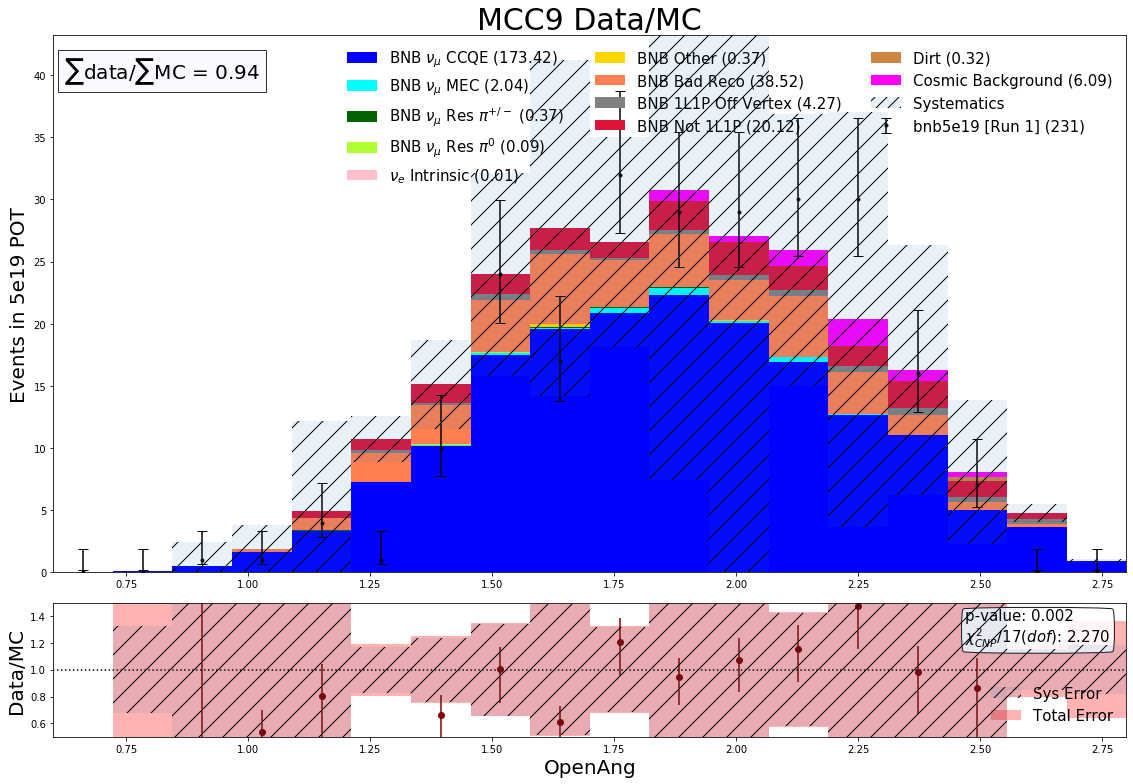

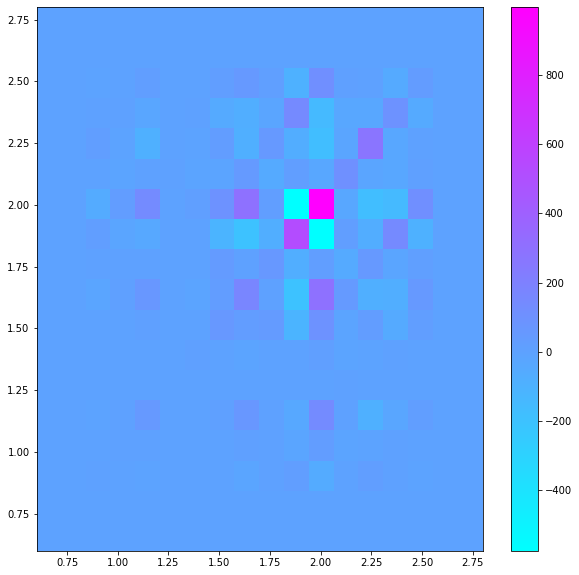

In [75]:
vartest = 'OpenAng'
varname = vartest
myrange = (.6,2.8)
scov = '../data/CovMatrices_May19_gevcut/covar_gevcut__openang_reco.txt'
legpos = 0

fig,ax0,_ = distplot_wratio_complicated(vartest,nbins,myrange,run1Hists,run1DataHist,varname,s_cov=scov)
#ax0.annotate(s_ano_simple,xy=(.75,.6), xycoords='axes fraction',fontsize=15)
#ax0.set_ylabel('Events in 1.5e20 POT',fontsize=20)


#mcplot(vartest,myrange,nbins,run1Hists,run1DataHist)

0.4128370226330726 0.9717417519643807


/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in true_divide


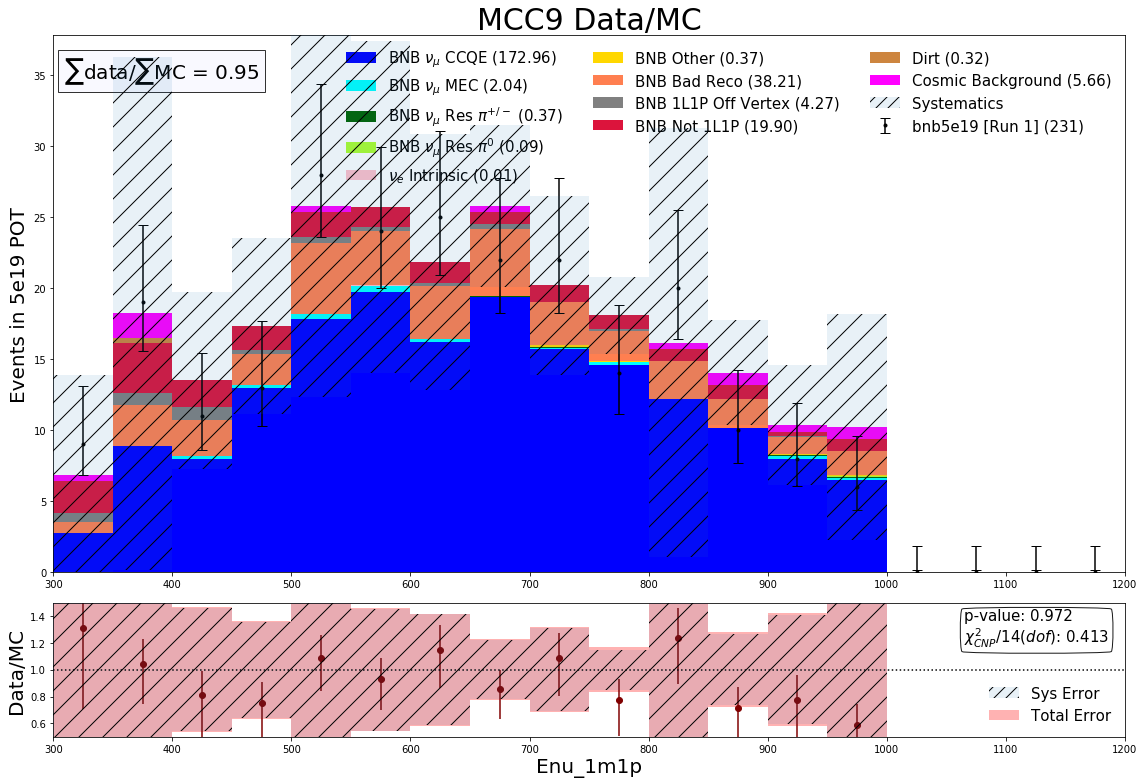

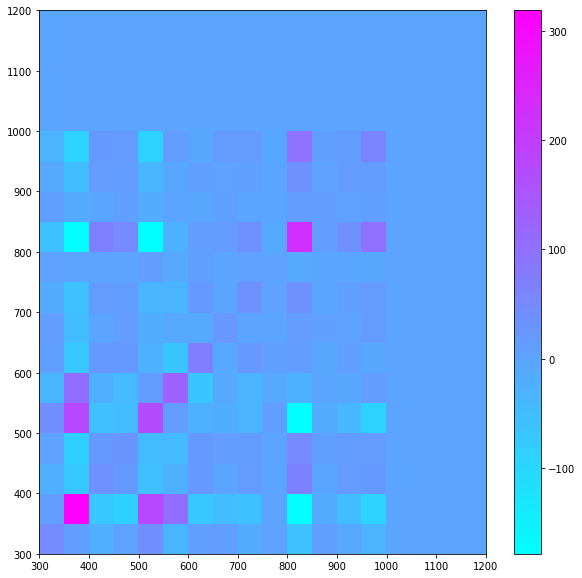

In [69]:
vartest = 'Enu_1m1p'
varname = vartest
myrange = (300,1200)
scov = '../data/CovMatrices_May19_gevcut/covar_gevcut__nu_energy_reco.txt'
legpos = 0

fig,ax0,_ = distplot_wratio_complicated(vartest,nbins,myrange,run1Hists,run1DataHist,varname,s_cov=scov)
#ax0.annotate(s_ano_simple,xy=(.75,.6), xycoords='axes fraction',fontsize=15)
#ax0.set_ylabel('Events in 1.5e20 POT',fontsize=20)


#mcplot(vartest,myrange,nbins,run1Hists,run1DataHist)

1.138365938887061 0.3058875110194139
1.163072071838723 0.2826899422303548
1.2271313282795686 0.22808568303315968
2.2702790534617674 0.0020345736188970287


/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in true_divide


2.885713715132502 0.00819502984425935
0.5319602391435142 0.9160854643243062


/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:141: RuntimeWarning: divide by zero encountered in true_divide


0.5597765221658902 0.9068983001548232
0.4128370226330726 0.9717417519643807
0.32661264659255046 0.9966628982485678
0.3272299252659259 0.996622078618737
0.30985934818469624 0.9976307393375505
0.9583859204721276 0.5059199352701765
0.7823782705751954 0.7076150992770643
0.3712429863910049 0.9887319162368631
0.3075398668212994 0.9977449646682985
0.460801946967259 0.9739235061665876
1.2660890108562792 0.19880515270454646
0.5759026133190632 0.9043202184941094
0.85192381553015 0.6388766488055575
0.8373130880512268 0.6435382946418361
1.213516454187375 0.23901666641045172


/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


0.2780448104235907 0.9984431902317354
1.2922620104572975 0.18076917443930862
0.7218341655646727 0.7433751894563816
1.2723003215178137 0.2045784400477726
0.8079157296888021 0.6931047784709834


OSError: DetSysCov/detsys_Proton_CosTheta_cov.csv not found.

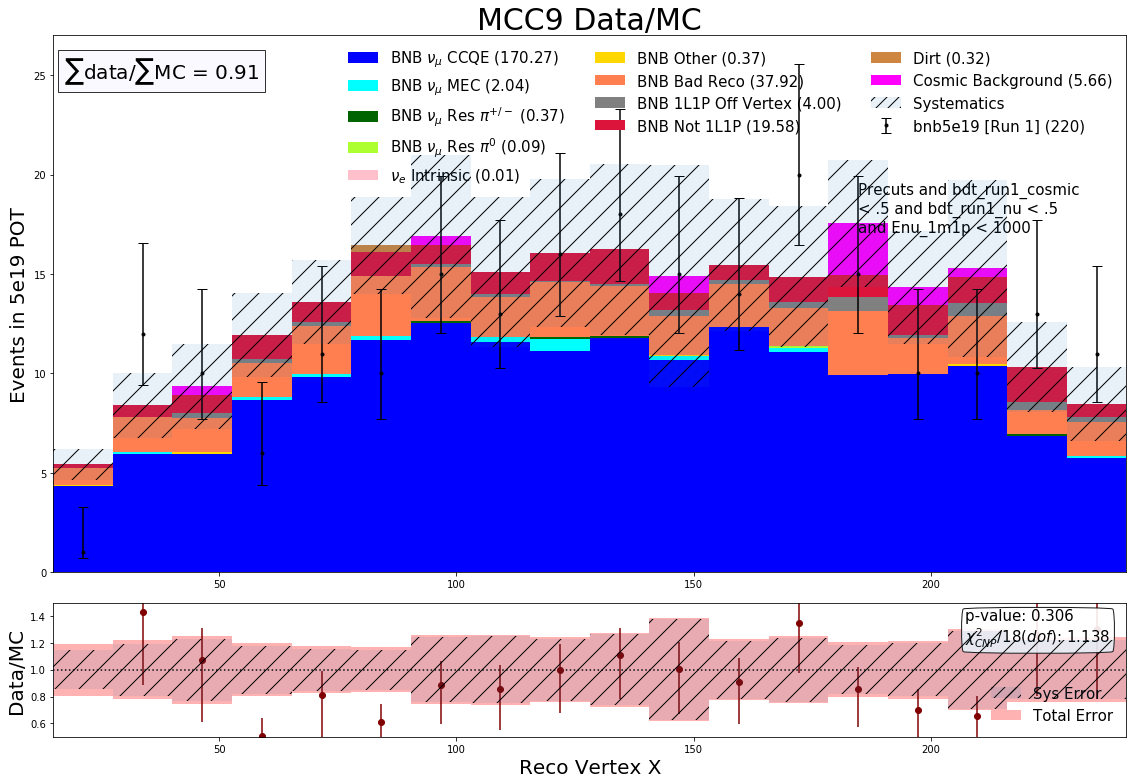

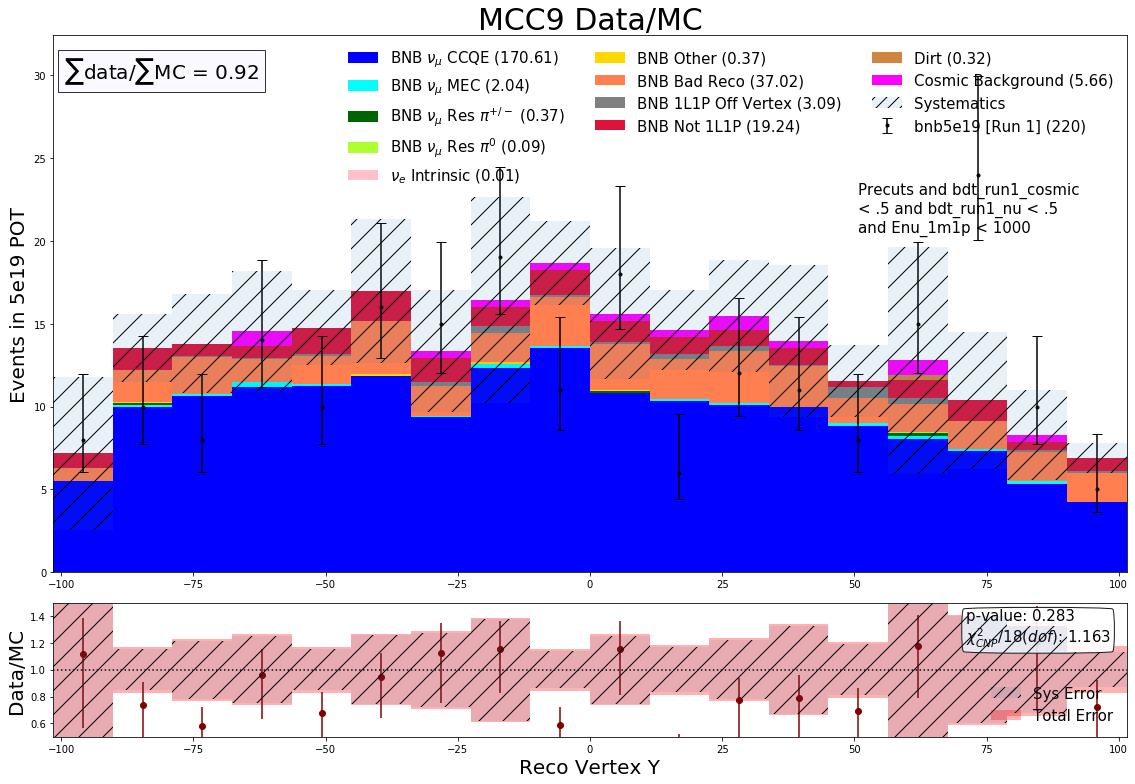

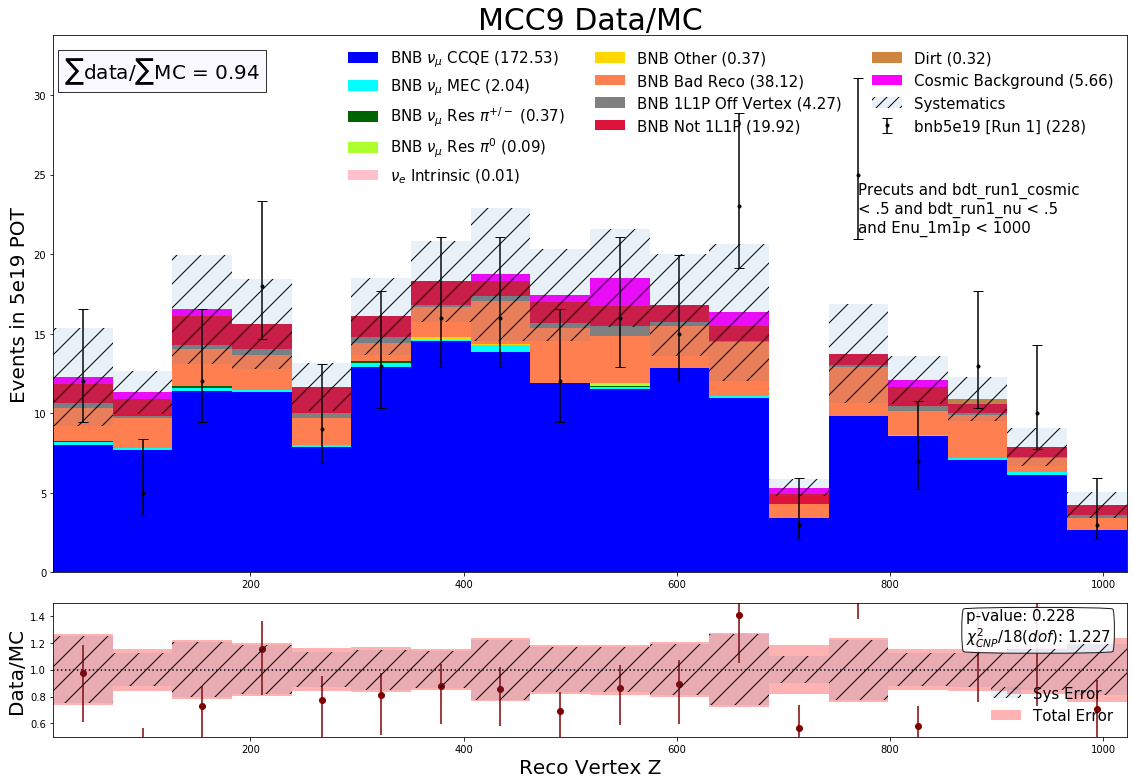

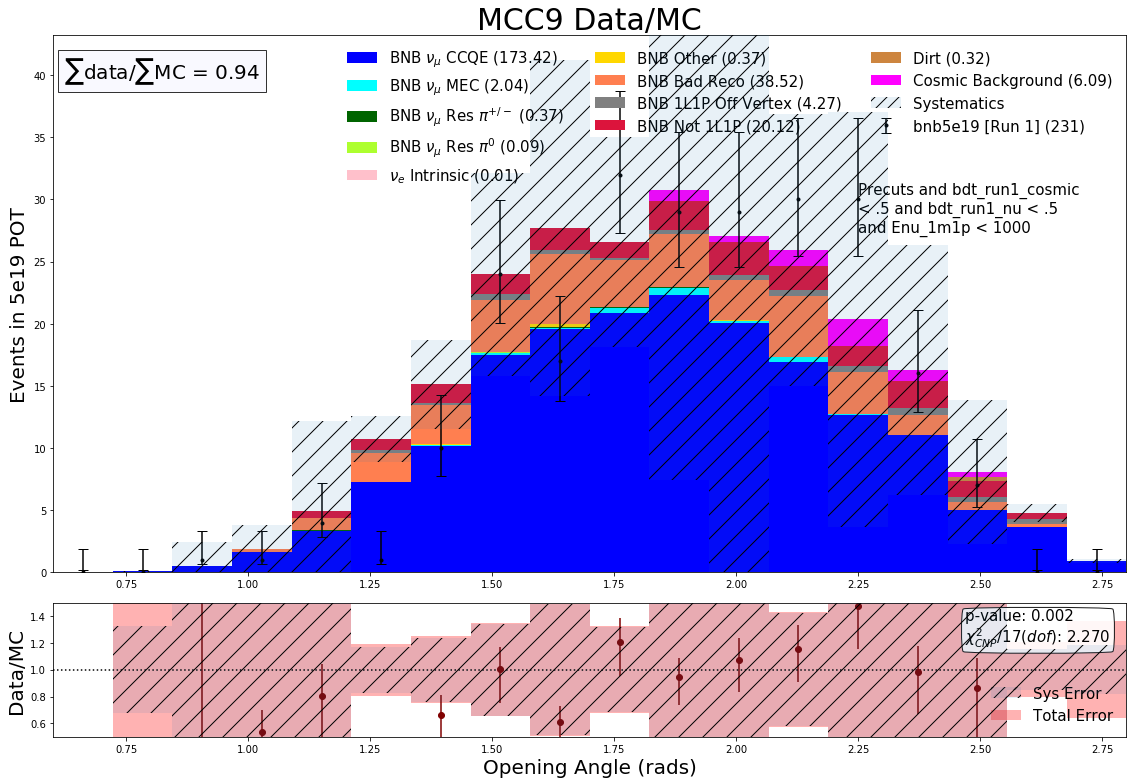

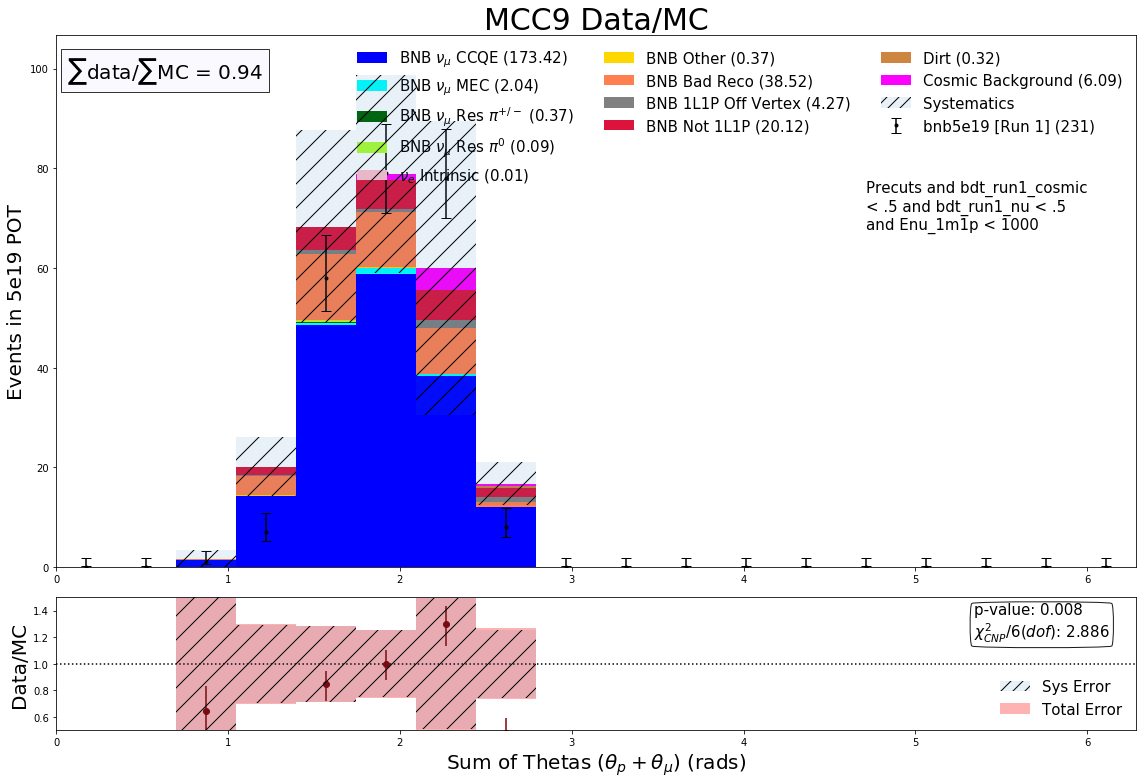

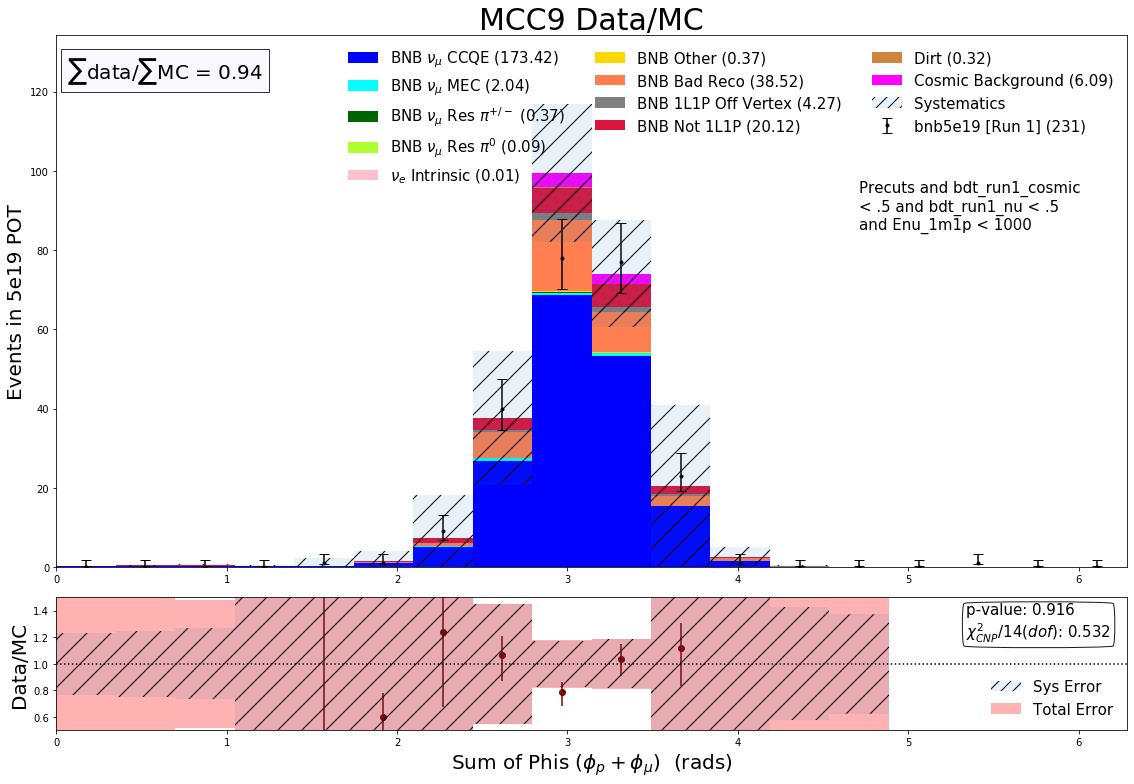

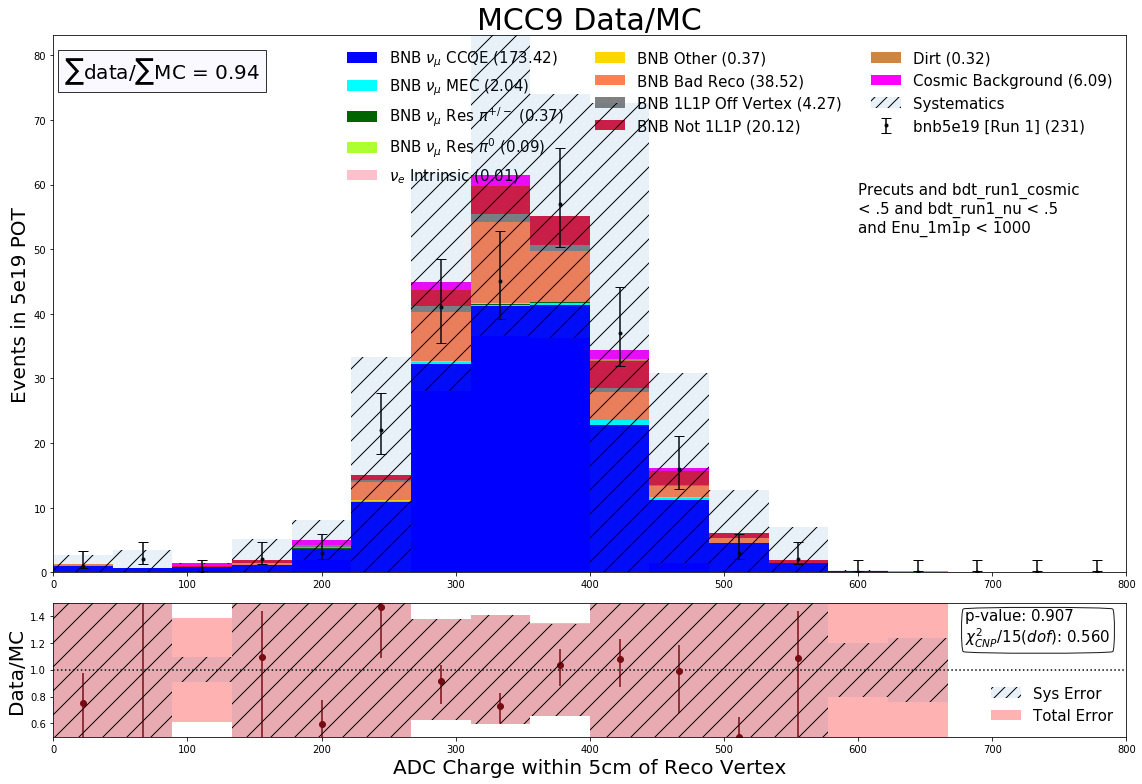

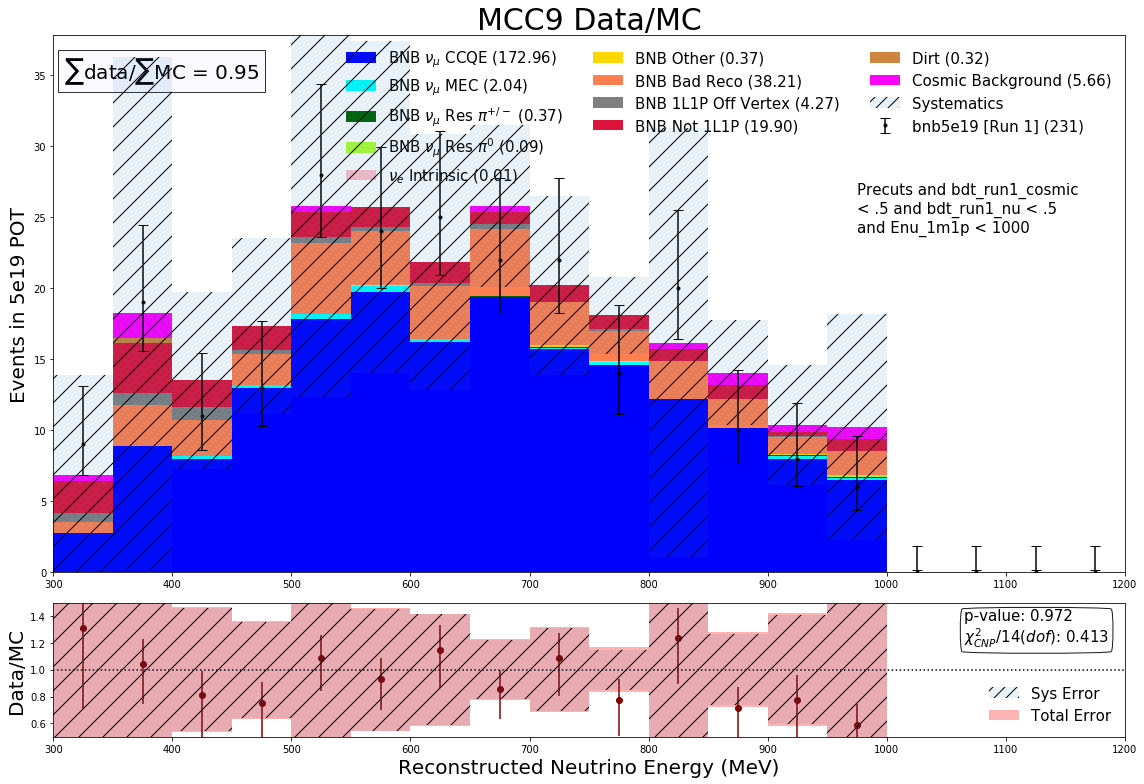

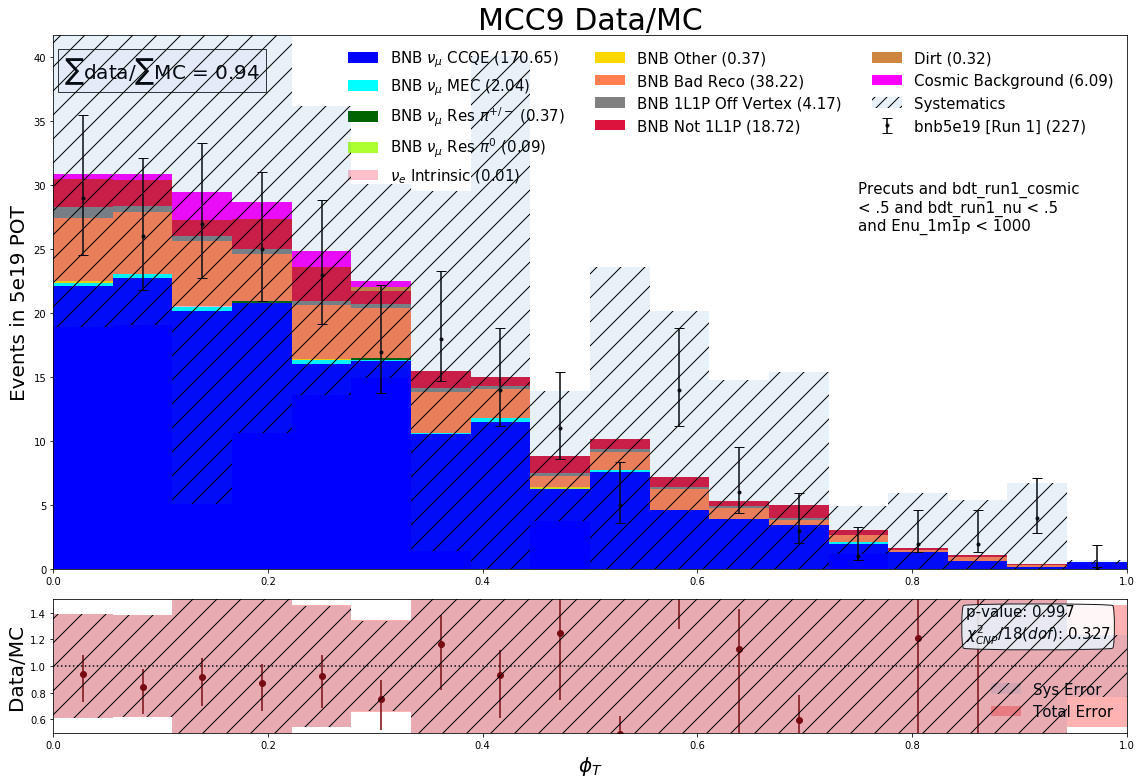

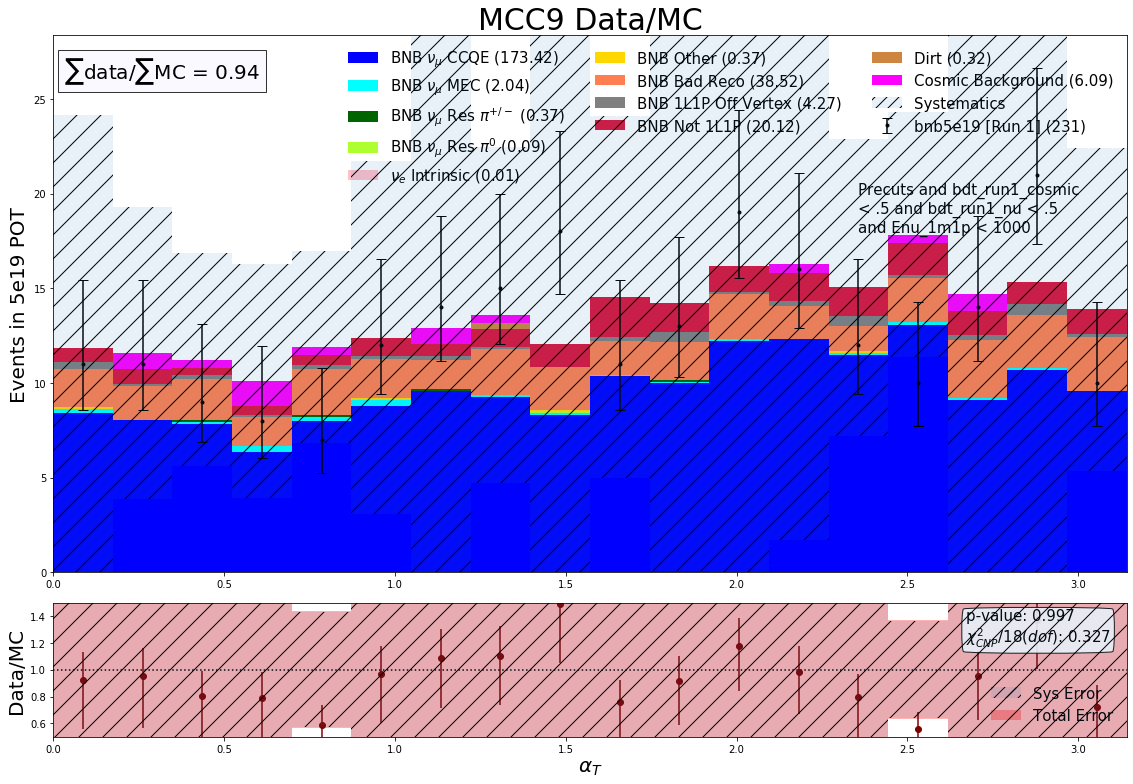

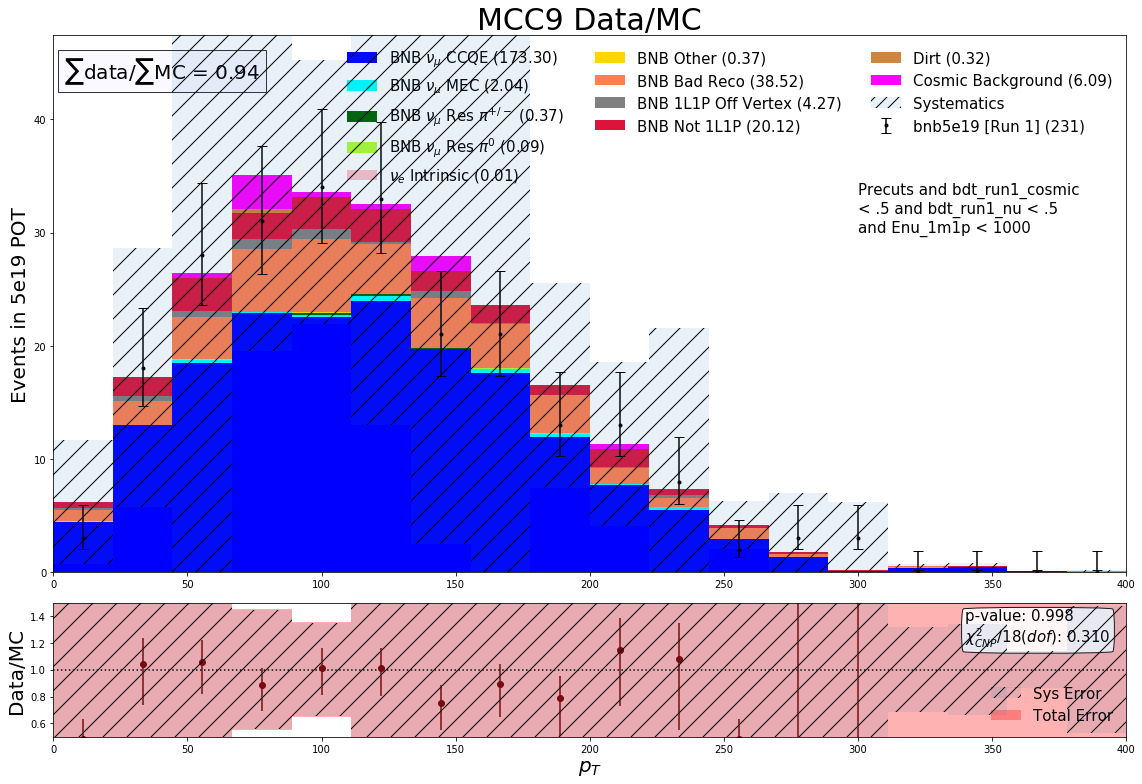

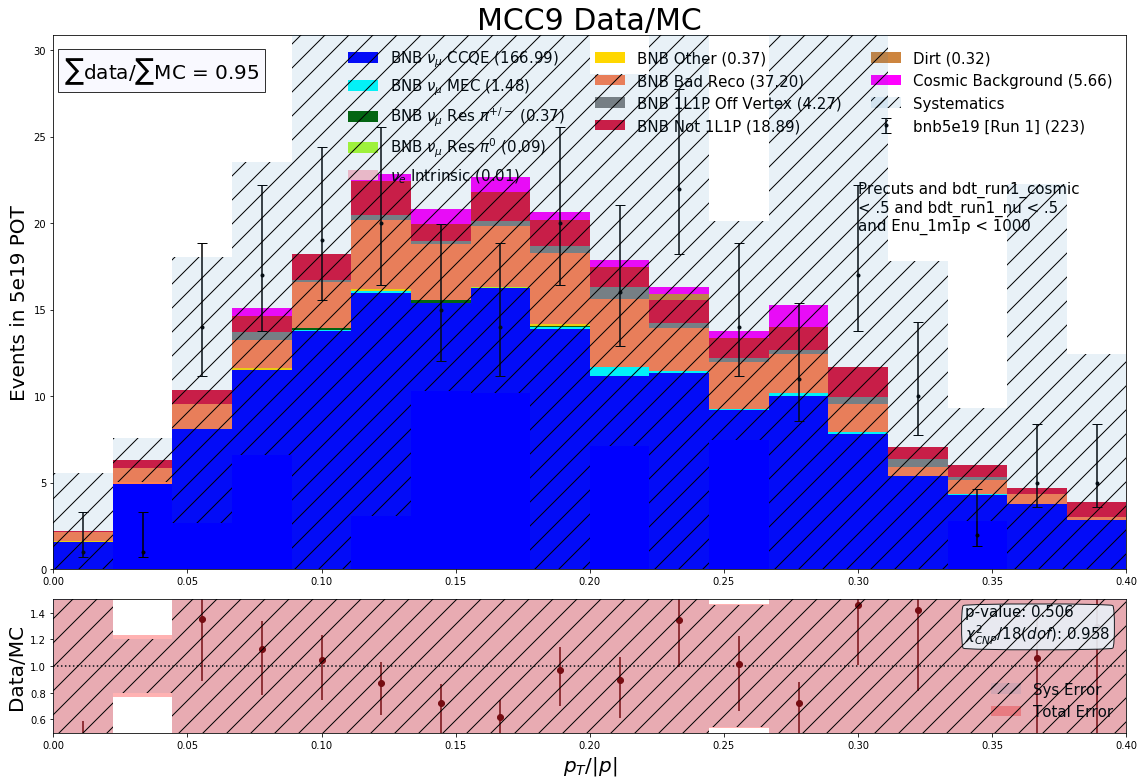

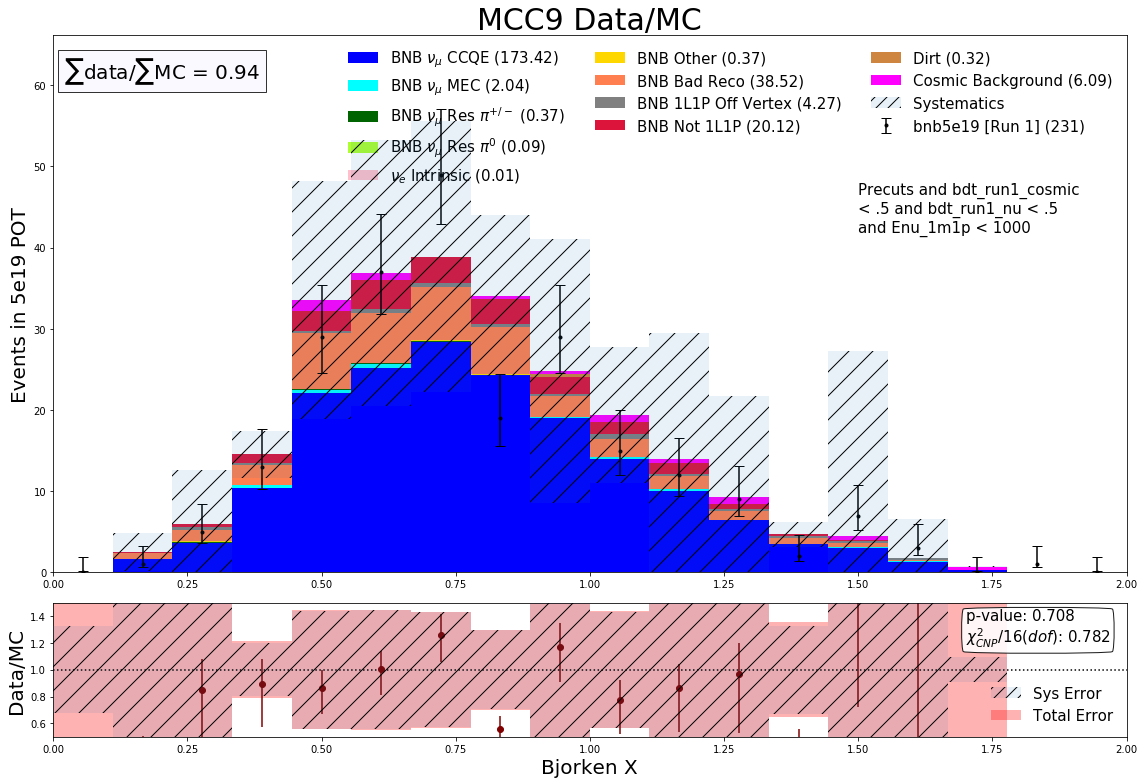

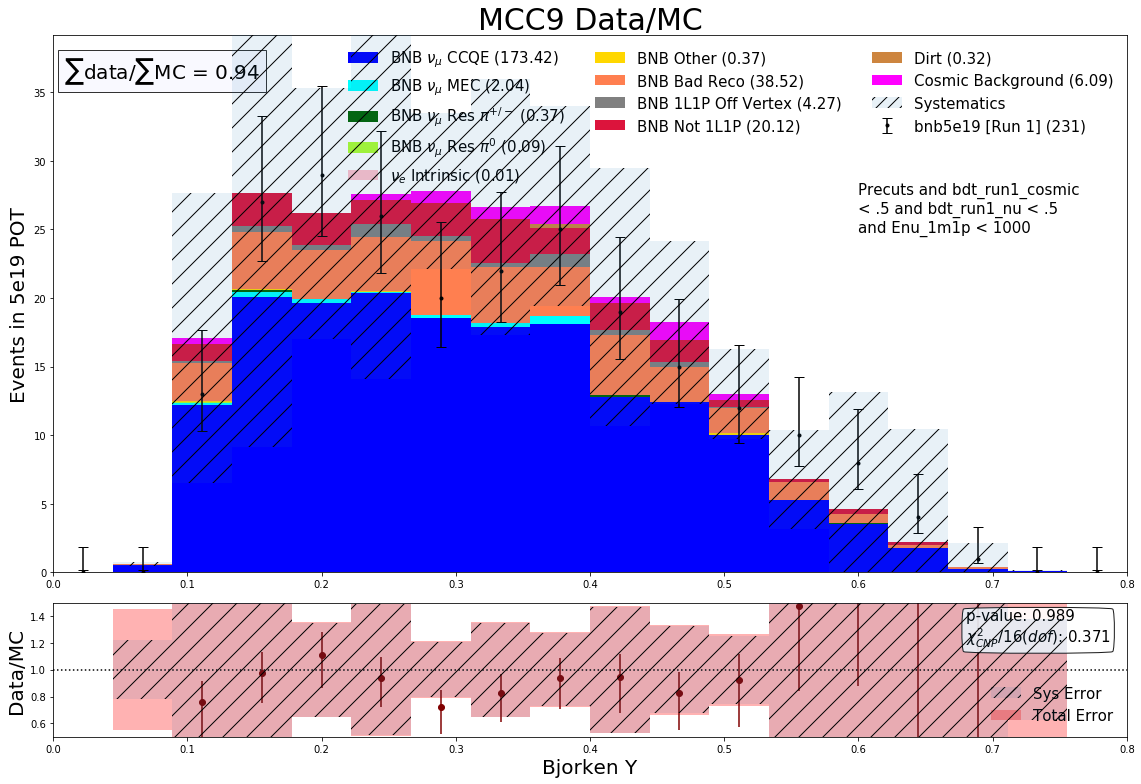

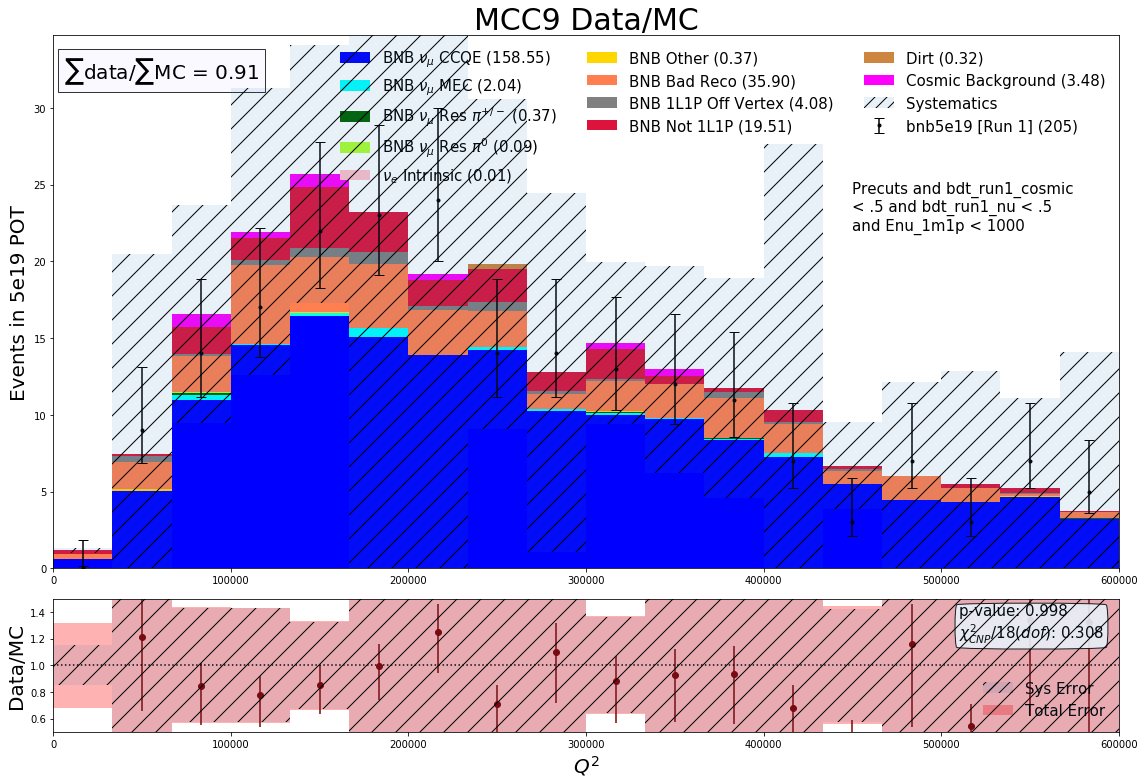

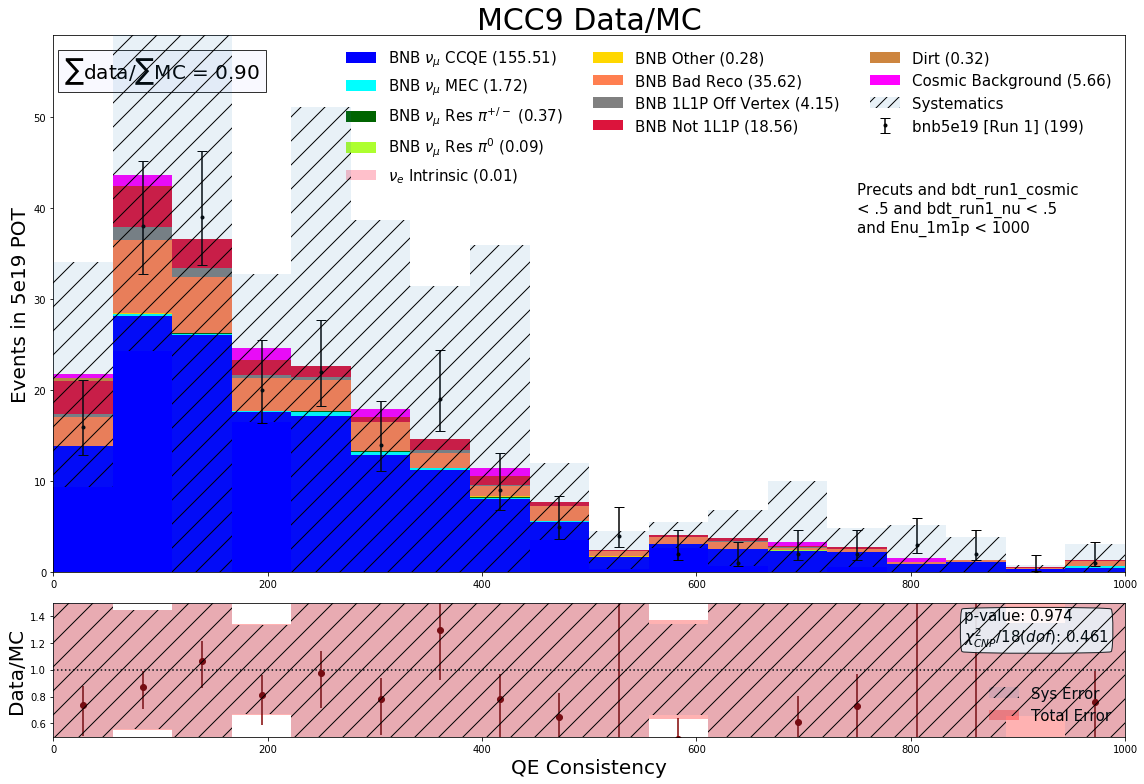

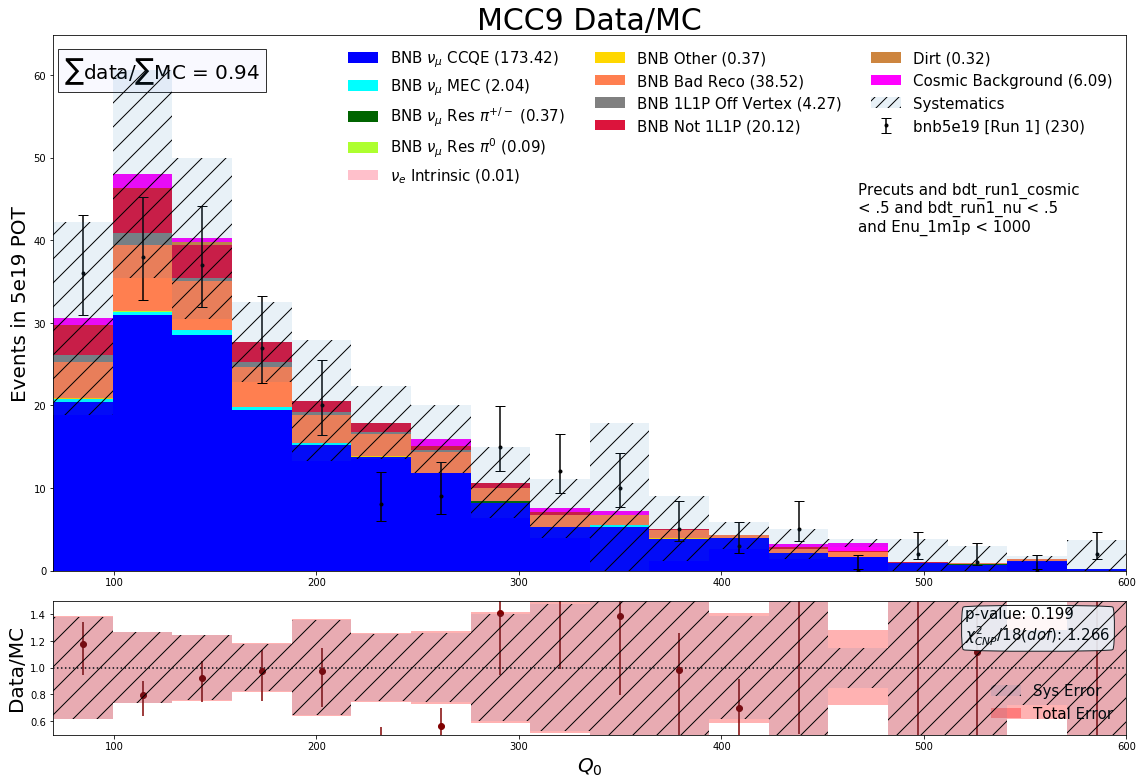

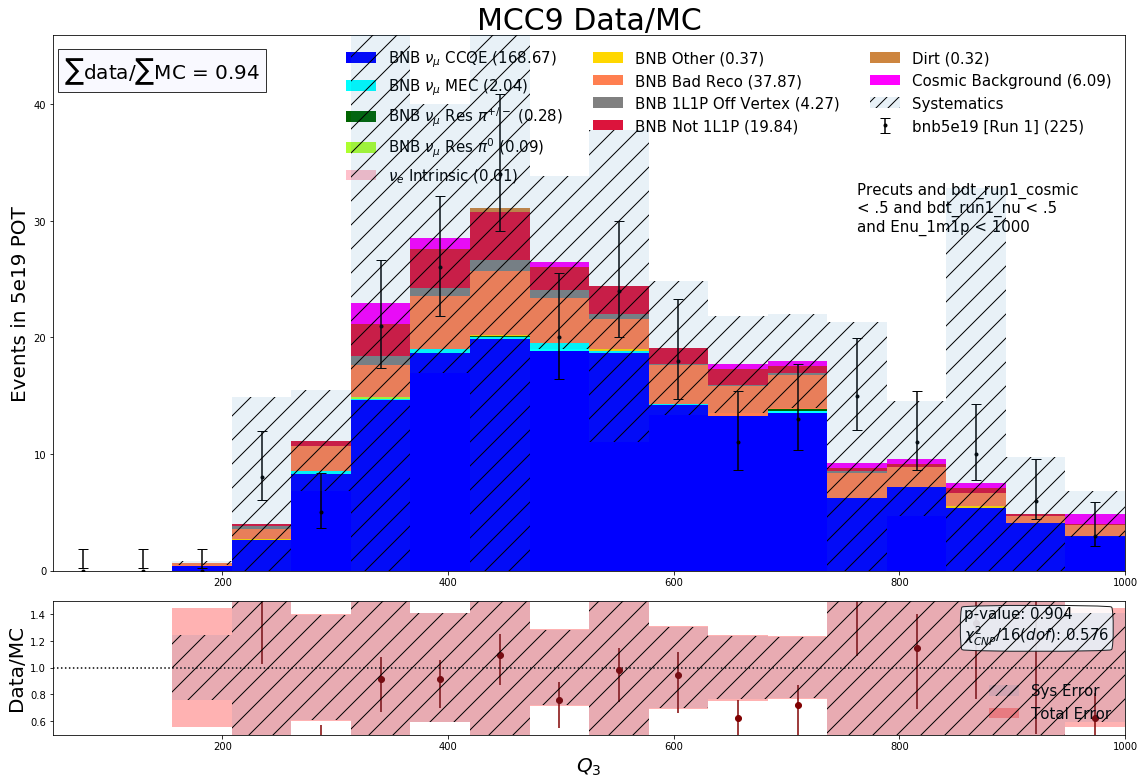

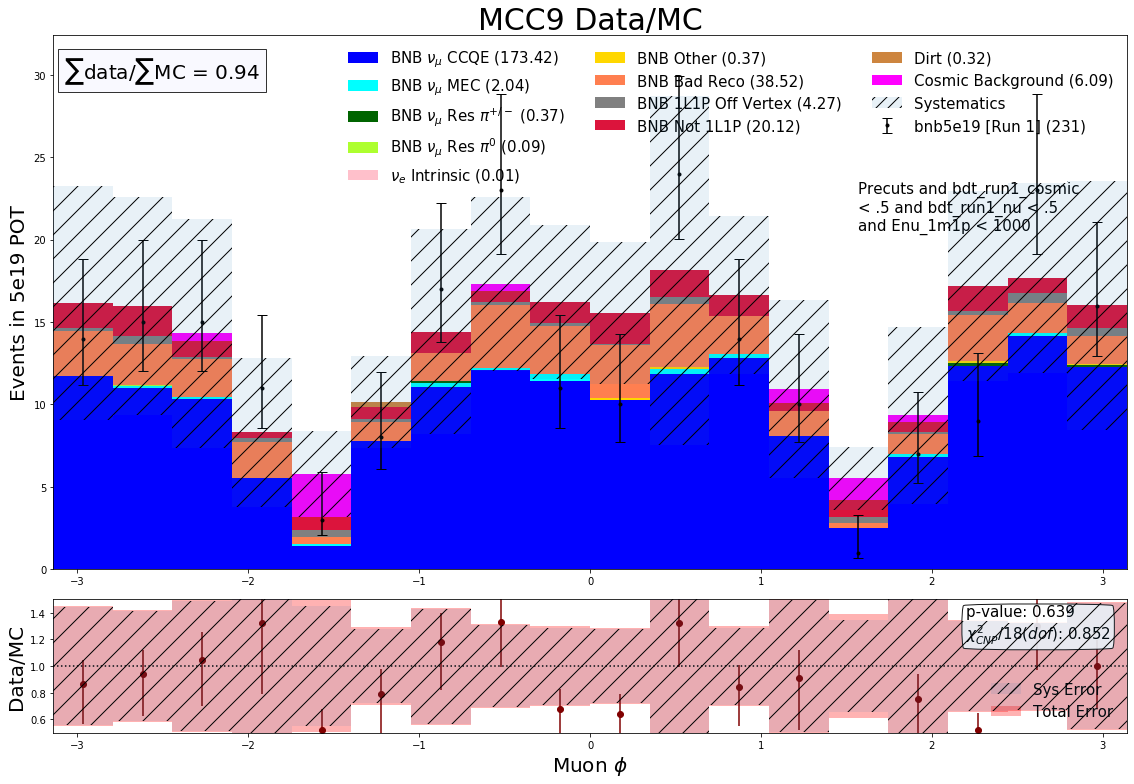

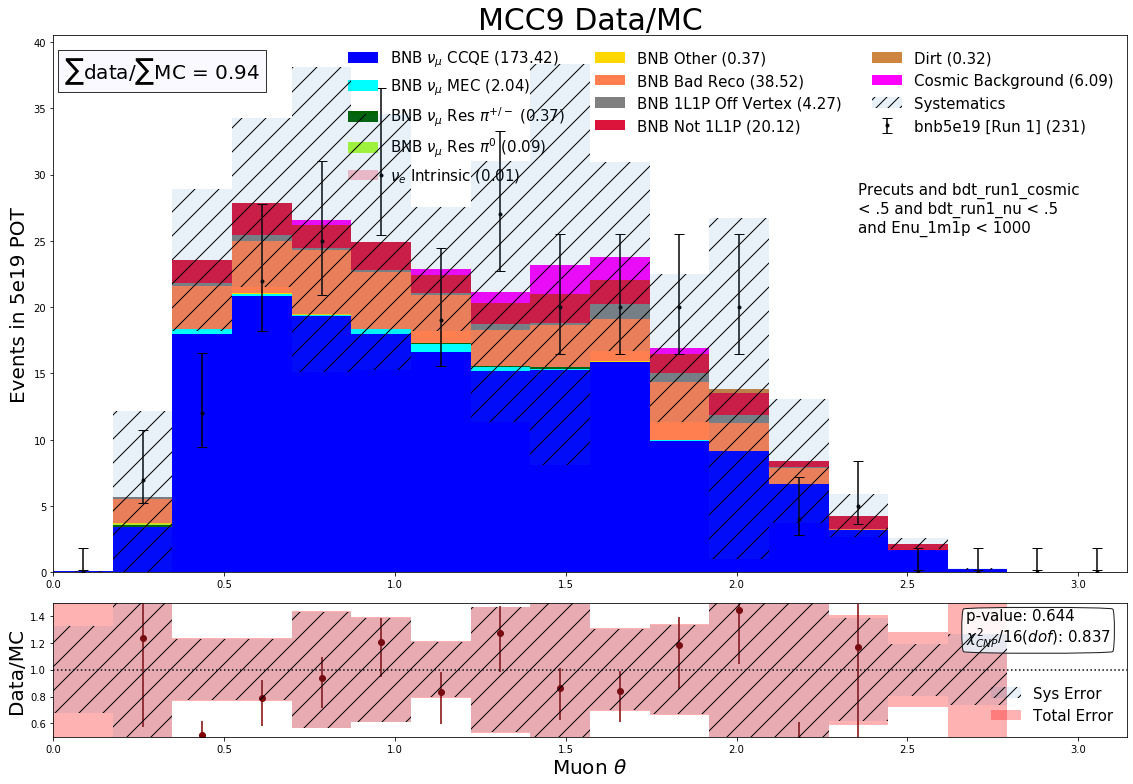

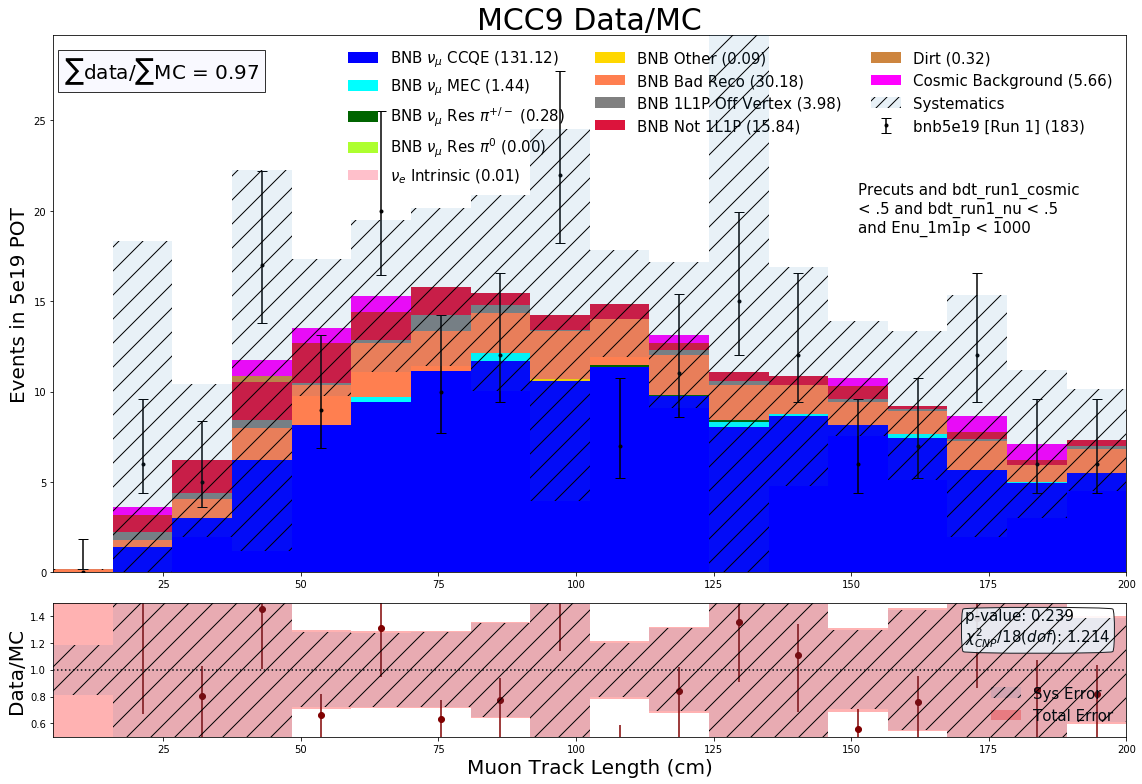

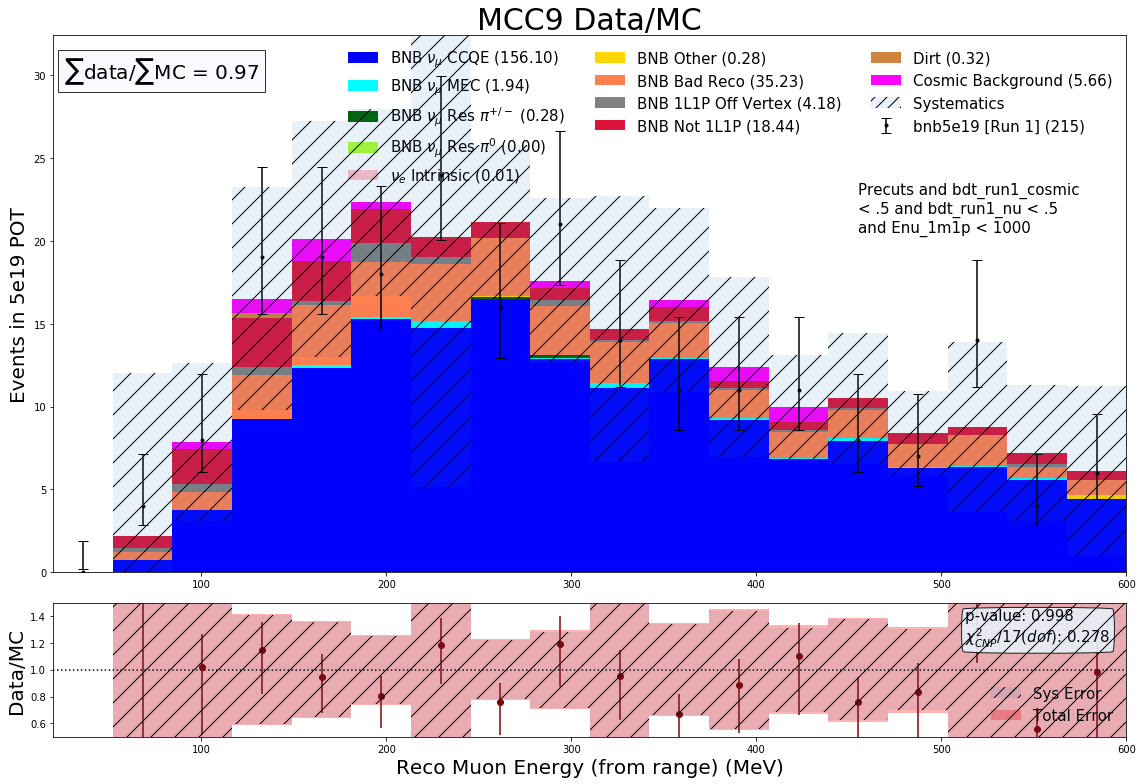

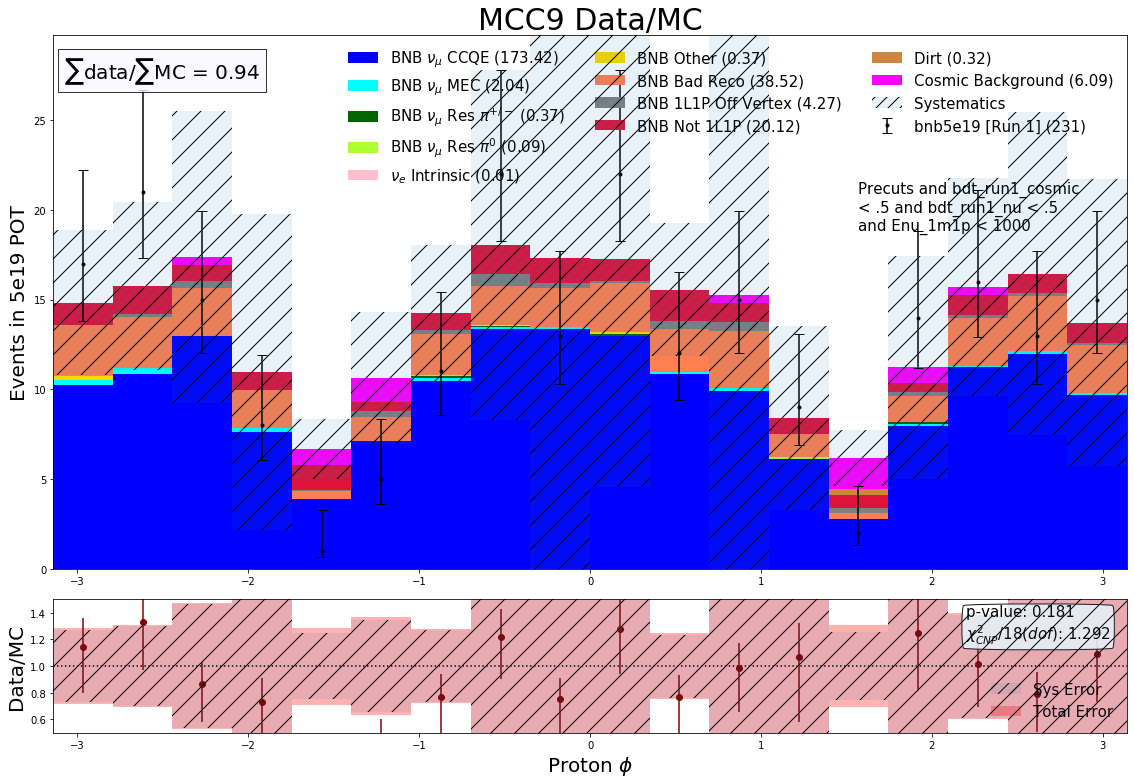

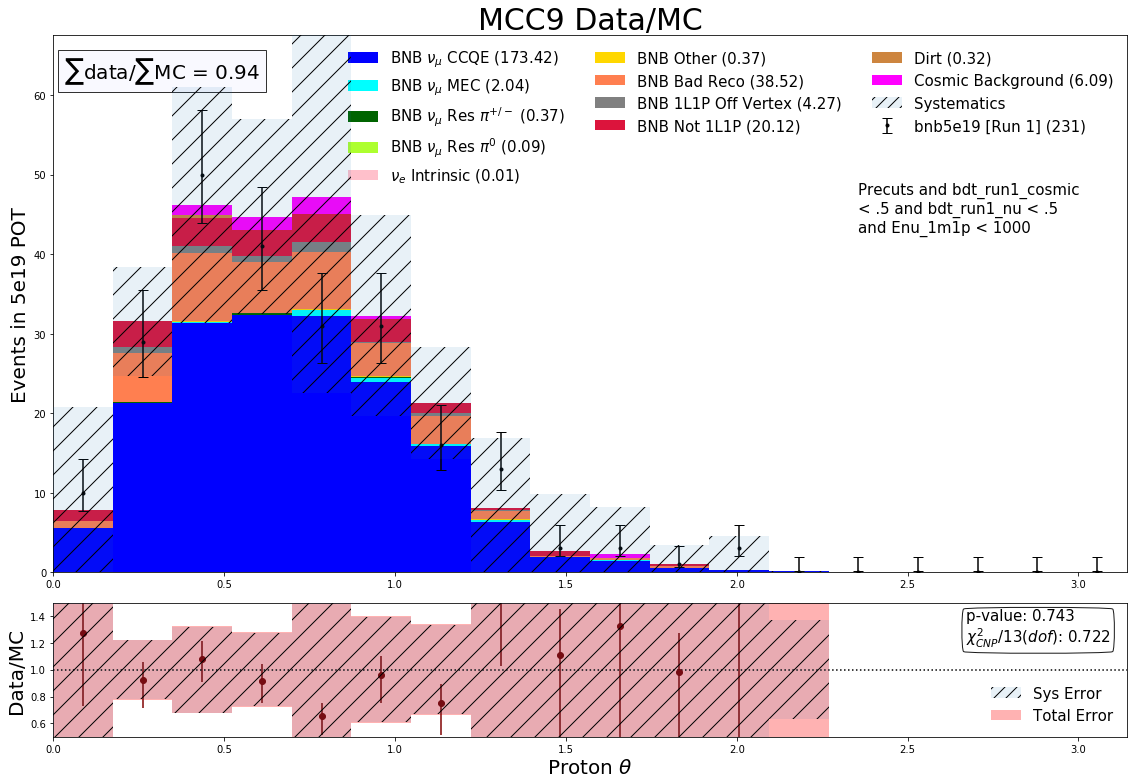

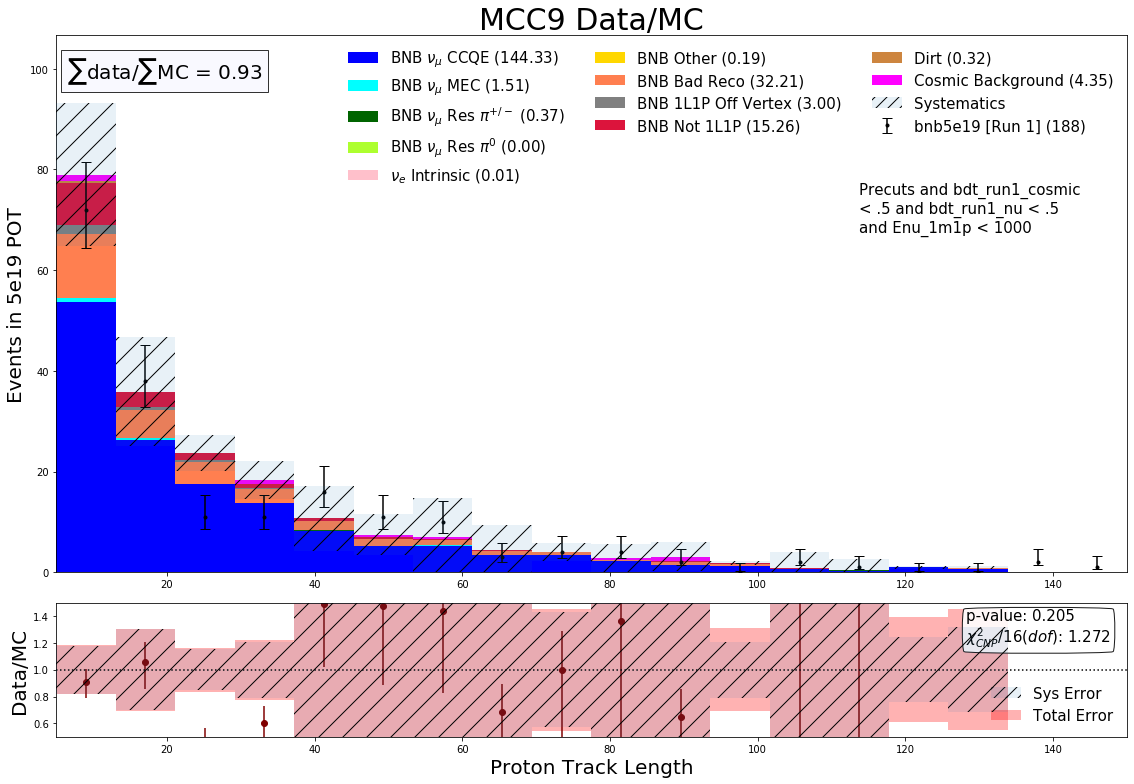

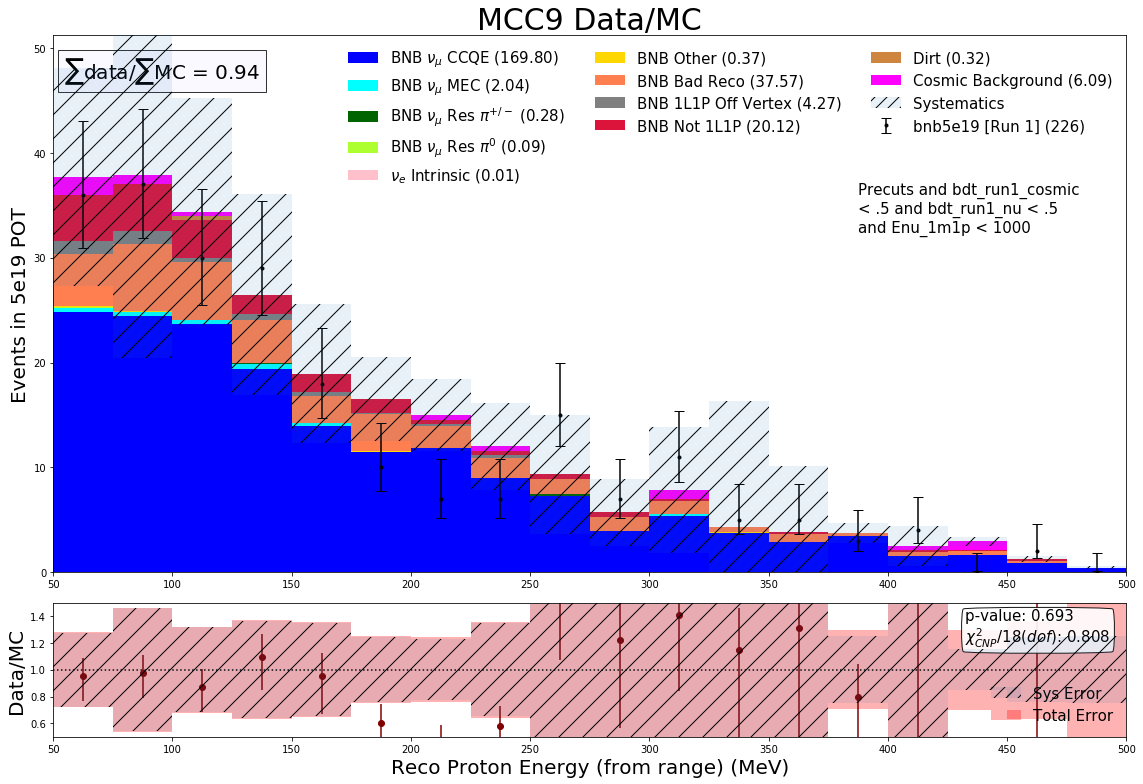

In [79]:
# Make big list of variables with their accompanying ranges so we can just dump a buttload of plots
varlistSel = []
covfolder = 'CovMatrices_May19_gevcut'

varlistSel.append(distVar('Xreco',(15,241.25),'Reco Vertex X','../data/'+covfolder+'/covar_gevcut__x_reco.txt'))
varlistSel.append(distVar('Yreco',(-101.5,101.5),'Reco Vertex Y','../data/'+covfolder+'/covar_gevcut__y_reco.txt'))
varlistSel.append(distVar('Zreco',(15,1021.8),'Reco Vertex Z','../data/'+covfolder+'/covar_gevcut__z_reco.txt'))
varlistSel.append(distVar('OpenAng',(.6,2.8),'Opening Angle (rads)','../data/'+covfolder+'/covar_gevcut__openang_reco.txt'))
varlistSel.append(distVar('Thetas',(0,2*np.pi),r'Sum of Thetas ($\theta_{p} + \theta_{\mu}$) (rads)','../data/'+covfolder+'/covar_gevcut__sum_thetas_reco.txt'))
varlistSel.append(distVar('Phis',(0,2*np.pi),r'Sum of Phis ($\phi_{p} + \phi_{\mu}$)  (rads)','../data/'+covfolder+'/covar_gevcut__sum_phis_reco.txt'))
varlistSel.append(distVar('ChargeNearTrunk',(0,800),'ADC Charge within 5cm of Reco Vertex','../data/'+covfolder+'/covar_gevcut__charge_near_trunk_reco.txt'))
varlistSel.append(distVar('Enu_1m1p',(300,1200),'Reconstructed Neutrino Energy (MeV)','../data/'+covfolder+'/covar_gevcut__nu_energy_reco.txt'))
varlistSel.append(distVar('PhiT_1m1p',(0,1),r'$\phi_T$','../data/'+covfolder+'/covar_gevcut__phiT_reco.txt'))
varlistSel.append(distVar('AlphaT_1m1p',(0,np.pi),r'$\alpha_T$','../data/'+covfolder+'/covar_gevcut__alphaT_reco.txt'))
varlistSel.append(distVar('PT_1m1p',(0,400),r'$p_T$','../data/'+covfolder+'/covar_gevcut__pT_reco.txt'))
varlistSel.append(distVar('PTRat_1m1p',(0,.4),r'$p_T/|p|$','../data/'+covfolder+'/covar_gevcut__pT_ratio_reco.txt'))
varlistSel.append(distVar('BjX_1m1p',(0,2),'Bjorken X','../data/'+covfolder+'/covar_gevcut__Bjx_reco.txt'))
varlistSel.append(distVar('BjY_1m1p',(0,.8),'Bjorken Y','../data/'+covfolder+'/covar_gevcut__Bjy_reco.txt'))
varlistSel.append(distVar('Q2_1m1p',(0,6e5),r'$Q^2$','../data/'+covfolder+'/covar_gevcut__Q2_reco.txt'))
varlistSel.append(distVar('Sph_1m1p',(0,1000),'QE Consistency','../data/'+covfolder+'/covar_gevcut__sph_reco.txt'))
varlistSel.append(distVar('PzEnu_1m1p',(-300,400),r'$p_z - E_\nu$ (MeV)'))
varlistSel.append(distVar('Q0_1m1p',(70,600),r'$Q_0$','../data/'+covfolder+'/covar_gevcut__Q0_reco.txt'))
varlistSel.append(distVar('Q3_1m1p',(50,1000),r'$Q_3$','../data/'+covfolder+'/covar_gevcut__Q3_reco.txt'))
varlistSel.append(distVar('Lepton_PhiReco',(-np.pi,np.pi),r'Muon $\phi$','../data/'+covfolder+'/covar_gevcut__lepton_phi_reco.txt'))
varlistSel.append(distVar('Lepton_ThetaReco',(0,np.pi),r'Muon $\theta$','../data/'+covfolder+'/covar_gevcut__lepton_theta_reco.txt'))
varlistSel.append(distVar('Lepton_TrackLength',(5,200),'Muon Track Length (cm)','../data/'+covfolder+'/covar_gevcut__lepton_length_reco.txt'))
varlistSel.append(distVar('Muon_Edep',(20,600),'Reco Muon Energy (from range) (MeV)','../data/'+covfolder+'/covar_gevcut__lepton_KE_reco.txt'))
varlistSel.append(distVar('Proton_PhiReco',(-np.pi,np.pi),r'Proton $\phi$','../data/'+covfolder+'/covar_gevcut__proton_phi_reco.txt'))
varlistSel.append(distVar('Proton_ThetaReco',(0,np.pi),r'Proton $\theta$','../data/'+covfolder+'/covar_gevcut__proton_theta_reco.txt'))
varlistSel.append(distVar('Proton_TrackLength',(5,150),'Proton Track Length','../data/'+covfolder+'/covar_gevcut__proton_length_reco.txt'))
varlistSel.append(distVar('Proton_Edep',(50,500),'Reco Proton Energy (from range) (MeV)','../data/'+covfolder+'/covar_gevcut__proton_KE_reco.txt'))
varlistSel.append(distVar('Proton_CosTheta',(-1,1),'Proton Cos Theta','../data/'+covfolder+'/covar_gevcut__proton_cos_theta_reco.txt'))
varlistSel.append(distVar('Lepton_CosTheta',(-1,1),'Muon Cos Theta','../data/'+covfolder+'/covar_gevcut__lepton_cos_theta_reco.txt'))

#Big Dumpus (for selected events)
dumphole = 'May20_finalsel_overlap'
mybins = 18

plt.ioff()

a_pval = []
a_varname = []

if not os.path.exists(dumphole):
    os.makedirs(dumphole)

for dist in varlistSel:
    if dist.myscov == '':
        continue
    fig,ax0,pval = distplot_wratio_complicated(dist.myname,nbins,dist.myrange,run1Hists,run1DataHist,dist.mylabel,s_cov=dist.myscov)
    ax0.annotate(s_ano_simple,xy=(.75,.6), xycoords='axes fraction',fontsize=15)
    #ax0.set_ylabel('Events in e20 POT',fontsize=20)
    plt.savefig(dumphole+'/'+dist.myname+'.png')
    a_pval.append(pval)
    a_varname.append(dist.myname)

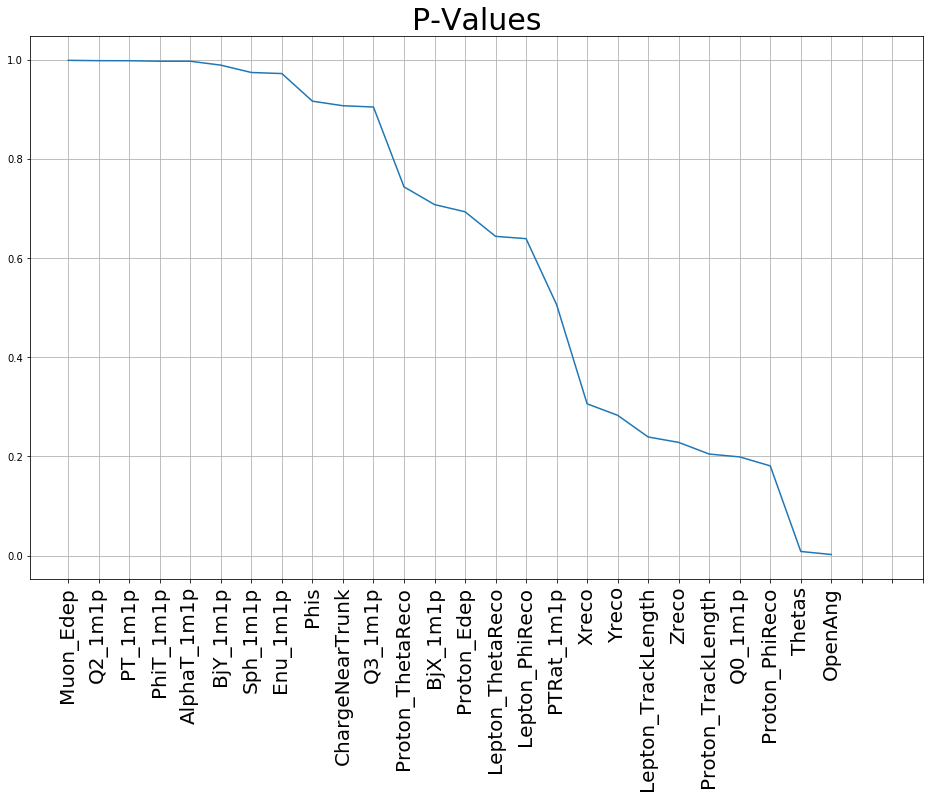

In [80]:
#scalesort = gh_scale[i].argsort()
#        sorted_vals = gh_vals[i][scalesort[::-1]]

psort = np.array(a_pval).argsort()
sorted_pval = np.array(a_pval)[psort[::-1]]
sorted_varname = np.array(a_varname)[psort[::-1]]
    
fig,ax = plt.subplots(figsize=(16,10))
ax.set_title('P-Values',fontsize=30)
plt.plot(range(len(sorted_pval)), sorted_pval)
plt.xticks(range(len(varlistSel)),sorted_varname, rotation='vertical',fontsize=20)
plt.grid(True)
plt.savefig(dumphole+'/pvals.png')

In [127]:
# Print RSE for lauren

selvars = ['run','subrun','event','Xreco','Yreco','Zreco','Eta','OpenAng','Thetas','Phis','ChargeNearTrunk','Enu_1m1p','PhiT_1m1p','AlphaT_1m1p','PT_1m1p','PTRat_1m1p','BjX_1m1p','BjY_1m1p','Q2_1m1p','Sph_1m1p','Q0_1m1p','Q3_1m1p','Lepton_PhiReco','Lepton_ThetaReco','Lepton_TrackLength','Muon_Edep','Lepton_CosTheta','Proton_PhiReco','Proton_ThetaReco','Proton_TrackLength','Proton_Edep','Proton_CosTheta']


df_numu_run1_presel.query(s_cuts)[selvars].to_csv('~/Downloads/numu_run1_gevcut-forlauren-may13.csv')
df_numu_run1_presel_lowe.query(s_cuts)[selvars].to_csv('~/Downloads/numu_run1_lowE_gevcut-forlauren-may13.csv')
#df_numu_run3_presel.query(s_cuts)[selvars].to_csv('~/Downloads/numu_run3-forlauren-may13.csv')
#df_numu_run3_presel_lowe.query(s_cuts)[selvars].to_csv('~/Downloads/numu_run3_lowE-forlauren-may13.csv')
df_nue_run1_presel.query(s_cuts)[selvars].to_csv('~/Downloads/nue_run1_gevcut-forlauren-may13.csv')
#df_nue_run3_presel.query(s_cuts)[selvars].to_csv('~/Downloads/nue_run3-forlauren-may13.csv')
df_ext_run1_presel.query(s_cuts)[selvars].to_csv('~/Downloads/ext_run1_gevcut-forlauren-may13.csv')
#df_ext_run3_presel.query(s_cuts)[selvars].to_csv('~/Downloads/ext_run3-forlauren-may13.csv')
df_dirt_run1_presel.query(s_cuts)[selvars].to_csv('~/Downloads/dirt_run1_gevcut-forlauren-may13.csv')

In [16]:
# Print for josh

selvars = ['run','subrun','event','Xreco','Yreco','Zreco','Eta','OpenAng','Thetas','Phis','ChargeNearTrunk','Enu_1m1p','PhiT_1m1p','AlphaT_1m1p','PT_1m1p','PTRat_1m1p','BjX_1m1p','BjY_1m1p','Q2_1m1p','Sph_1m1p','Q0_1m1p','Q3_1m1p','Lepton_PhiReco','Lepton_ThetaReco','Lepton_TrackLength','Muon_Edep','Lepton_CosTheta','Proton_PhiReco','Proton_ThetaReco','Proton_TrackLength','Proton_Edep','Proton_CosTheta']


df_numu_run1_presel.query(s_cuts+' and MC_energyInit > 400').to_parquet('~/Downloads/numu_run1_finalsel-forjosh-may19.parquet')
df_numu_run1_presel_lowe.query(s_cuts).to_parquet('~/Downloads/numu_run1_lowE_finalsel-forjosh-may19.parquet')
df_nue_run1_presel.query(s_cuts).to_parquet('~/Downloads/nue_run1_finalsel-forjosh-may19.parquet')
df_ext_run1_presel.query(s_cuts).to_parquet('~/Downloads/ext_run1_finalsel-forjosh-may19.parquet')
df_dirt_run1_presel.query(s_cuts).to_parquet('~/Downloads/dirt_run1_finalsel-forjosh-may19.parquet')
df_data_run1_presel.query(s_cuts).to_parquet('~/Downloads/data_run1_finalsel-forjosh-may19.parquet')

In [ ]:
var1 = 'Xreco'
var2 = 'TotPE'
#ext_var1 = (df_ext_sel[var1].values)
#ext_var2 = (df_ext_sel[var2].values)

#numu_var1 = (df_numu_CCQE_sel[var1].values)
#numu_var2 = (df_numu_CCQE_sel[var2].values)

ext_var1 = (df_data_presel[var1].values)
ext_var2 = (df_data_presel[var2].values)

numu_var1 = (df_numu_CCQE_presel[var1].values)
numu_var2 = (df_numu_CCQE_presel[var2].values)

print(numu_var2.max())

fig,ax = plt.subplots(figsize=(9,9))
sns.set_style('ticks')
plt.scatter(numu_var1,numu_var2,color='lavender',alpha=1)
plt.scatter(ext_var1,ext_var2,color='mistyrose',alpha=.9)
sns.kdeplot(numu_var1,numu_var2,label='numu CCQE MC',color='blue',cmap='Blues')#,cmap="Greens", shade=True, bw=.15)
sns.kdeplot(ext_var1,ext_var2,label='data',color='red',cmap='Reds')#,cmap="Reds", shade=True, bw=.15)

ax.set_xlabel(var1,fontsize=20)
ax.set_ylabel(var2,fontsize=20)
plt.legend(fontsize=20,loc='upper right')
#plt.yscale('log')
#plt.xscale('log')
plt.xlim(0,256)
plt.ylim(0,2000)

x0 = np.linspace(0,6)
y0 = -(x0)*300+250
y1 = (x0-2.6)*600

#plt.plot(x0,y0,c='coral')
#plt.plot(x0,y1,c='ofrange')
#ax.axvline(2.8)

In [ ]:
df_numu_total = pd.read_parquet('../data/pickles/numu_nodupes_%s.parquet'%tag).query("mc_label in ['numu_CCQE']")

with open('/home/dcianci/Physics/1e1p/1mu1pSelection/bdtweights_1mu1p_WC_apr1.pickle','rb') as handle: cosmicBDT,nubkgBDT = pickle.load(handle)          # Load BDT weights for 1mu1p background differentiation
    
vars_cos_allofem = ['Eta','ChargeNearTrunk','PT_1m1p','PhiT_1m1p','AlphaT_1m1p','Sph_1m1p','Q0_1m1p','Q2_1m1p','Q3_1m1p','Lepton_ThetaReco','Lepton_PhiReco','Proton_ThetaReco','Proton_PhiReco','PTRat_1m1p','Lepton_TrackLength','Thetas','Phis','Proton_TrackLength','OpenAng','PzEnu_1m1p']

myvars = vars_cos_allofem
s_nubdtname = 'NuBkgScore'
s_cosbdtname = 'CosmicBkgScore'
for i in range(len(sampleHists)):
    df_numu_total.insert(0,s_nubdtname,nubkgBDT.predict(df_numu_total[myvars].values.tolist(),output_margin=True))
    df_numu_total.insert(0,s_cosbdtname,cosmicBDT.predict(df_numu_total[myvars].values.tolist(),output_margin=True))
 

In [ ]:
nbins = 18
myrange=(0,2000)
vartest = 'MC_energyInit'

orthogonalcut = 'MaxShrFrac < .2'
precuts = 'OpenAng > .5 and ChargeNearTrunk > 0 and FailedBoost != 1 and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15'
coscut = 'CosmicBkgScore > 0'
nucut = 'NuBkgScore > 0'

#varlist.append(distVar('Q2_1m1p',(0,6e5),r'$Q^2$','../data/CovMatrices_Apr20/covar_postsel__Q2_reco.txt'))
#varlist.append(distVar('Q0_1m1p',(70,600),r'$Q_0$','../data/CovMatrices_Apr20/covar_postsel__Q0_reco.txt'))
#varlist.append(distVar('Q3_1m1p',(50,1000),r'$Q_3$','../data/CovMatrices_Apr20/covar_postsel__Q3_reco.txt'))



val_total,binedges = np.histogram(df_numu_total[vartest].values,bins=nbins,range=myrange)
bincenters = np.diff(binedges)/2 + binedges[:-1]

fig,ax = plt.subplots(figsize=(16,10))

val1_cut,_ = np.histogram(df_numu_total.query('PassSimpleCuts == 1')[vartest].values,bins=nbins,range=myrange)
ax.errorbar(bincenters,np.divide(val1_cut,val_total),label='Pass Simple Cuts',yerr=np.sqrt(val1_cut)/val_total,fmt='o',c='orange')

val2_cut,_ = np.histogram(df_numu_total.query('PassSimpleCuts == 1 and MaxShrFrac < .2 and OpenAng > .5 and ChargeNearTrunk > 0 and FailedBoost != 1 and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15')[vartest].values,bins=nbins,range=myrange)
ax.errorbar(bincenters,np.divide(val2_cut,val_total),label='Pass All Precuts',yerr=np.sqrt(val2_cut)/val_total,fmt='o',c='green')

val4_cut,_ = np.histogram(df_numu_total.query('PassSimpleCuts == 1 and MaxShrFrac < .2 and OpenAng > .5 and ChargeNearTrunk > 0 and FailedBoost != 1 and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15 and CosmicBkgScore > 0 and NuBkgScore > 0')[vartest].values,bins=nbins,range=myrange)
ax.errorbar(bincenters,np.divide(val4_cut,val_total),label='Pass Full Selection',yerr=np.sqrt(val4_cut)/val_total,fmt='o',c='violet',capsize=3)


ax.set_ylim(0,1)
    
ax.set_xlabel(r'True Neutrino Energy',fontsize=20)
ax.set_ylabel('Efficiency',fontsize=20)
ax.legend(fontsize=20)

## mostly experimental  2d  plots

In [74]:
mchist = run1Hists
datahist = run1DataHist

#df_bkg = df_numu_presel.query("mc_label not in ['numu_CCQE']")
#df_nubkg = df_numu_presel.query("mc_label not in ['numu_CCQE'] or not "+goodreco+' or MC_nproton!=1 or MC_nlepton!=1')

#with open('/home/dcianci/Physics/1e1p/1mu1pSelection/bdtweights_1mu1p_WC_mar26-deepcuts.pickle','rb') as handle: cosmicBDT,nuBDT = pickle.load(handle)          # Load BDT weights for 1mu1p background differentiation
#vars_cos_allofem = ['Eta','ChargeNearTrunk','PT_1m1p','PhiT_1m1p','AlphaT_1m1p','Sph_1m1p','Q0_1m1p','Q2_1m1p','Q3_1m1p','Lepton_ThetaReco','Lepton_PhiReco','Proton_ThetaReco','Proton_PhiReco','PTRat_1m1p','Lepton_TrackLength','Thetas','Phis','Proton_TrackLength','OpenAng','PzEnu_1m1p']
#myvars = vars_cos_allofem
#df_sig.insert(0,'NuBkgScore1',nuBDT.predict(df_nusignal[myvars].values.tolist(),output_margin=True))
#df_bkg.insert(0,'NuBkgScore1',nuBDT.predict(df_extbkg[myvars].values.tolist(),output_margin=True))
#df_nubkg.insert(0,'NuBkgScore1',nuBDT.predict(df_nubkg[myvars].values.tolist(),output_margin=True))


var1 = 'Lepton_ThetaReco'
var2 = 'OpenAng'

a_var1,_,_,a_wgt_var1,_ = mchist.GetHists(var1)
a_var2,_,_,a_wgt_var2,_ = mchist.GetHists(var2)
data_var1,_,_,data_wgt_var1,_ = datahist.GetHists(var1)
data_var2,_,_,data_wgt_var2,_ = datahist.GetHists(var2)



fig,ax = plt.subplots(figsize=(9,9))
sns.set_style('ticks')
#plt.scatter(bkg1_var1,bkg1_var2,color='mistyrose',alpha=.9)
#plt.scatter(bkg2_var1,bkg2_var2,color='honeydew',alpha=.9)
plt.scatter(sig_var1,sig_var2,color='lavender',alpha=1)


#sns.kdeplot(bkg1_var1,bkg1_var2,label='bkg',color='blue',cmap='Blues')#,cmap="Greens", shade=True, bw=.15)
#sns.kdeplot(bkg2_var1,bkg2_var2,label='nubkg',color='green',cmap='Greens')#,cmap="Reds", shade=True, bw=.15)
sns.kdeplot(sig_var1,sig_var2,label='signal',color='blue',cmap='Blues')#,cmap="Reds", shade=True, bw=.15)

ax.set_xlabel(var1,fontsize=20)
ax.set_ylabel(var2,fontsize=20)
plt.legend(fontsize=20,loc='lower right')
plt.xlim(0,np.pi)
plt.ylim(0,np.pi)

TypeError: 'StackedHisto' object does not support indexing

(-1, 1)

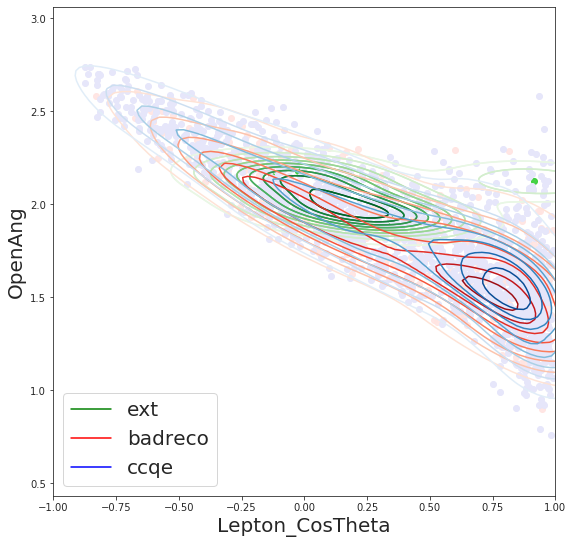

In [83]:
var1 = 'Lepton_CosTheta'
var2 = 'OpenAng'

mc_vars1,_,_,_,_ = run1Hists.GetHists(var1)
mc_vars2,_,_,_,_ = run1Hists.GetHists(var2)


ccqe_var1 = mc_vars1[0]
ccqe_var2 = mc_vars2[0]

badreco_var1 = mc_vars1[6]
badreco_var2 = mc_vars2[6]

cos_var1 = mc_vars1[-1]
cos_var2 = mc_vars2[-1]

fig,ax = plt.subplots(figsize=(9,9))
sns.set_style('ticks')
sns.kdeplot(cos_var1,cos_var2,color='green',cmap='Greens')#,cmap="Greens", shade=True, bw=.15)
plt.scatter(cos_var1,cos_var2,color='limegreen',alpha=.9)
plt.scatter(badreco_var1,badreco_var2,color='mistyrose',alpha=.9)
plt.scatter(ccqe_var1,ccqe_var2,color='lavender',alpha=1)


sns.kdeplot(cos_var1,cos_var2,label='ext',color='green',cmap='Greens')#,cmap="Greens", shade=True, bw=.15)
sns.kdeplot(badreco_var1,badreco_var2,label='badreco',color='red',cmap='Reds')#,cmap="Reds", shade=True, bw=.15)
sns.kdeplot(ccqe_var1,ccqe_var2,label='ccqe',color='blue',cmap='Blues')#,cmap="Greens", shade=True, bw=.15)



ax.set_xlabel(var1,fontsize=20)
ax.set_ylabel(var2,fontsize=20)
plt.legend(fontsize=20)
#plt.yscale('log')
#plt.xscale('log')
plt.xlim(-1,1)
#Eplt.ylim(0,1)



(-1, 1)

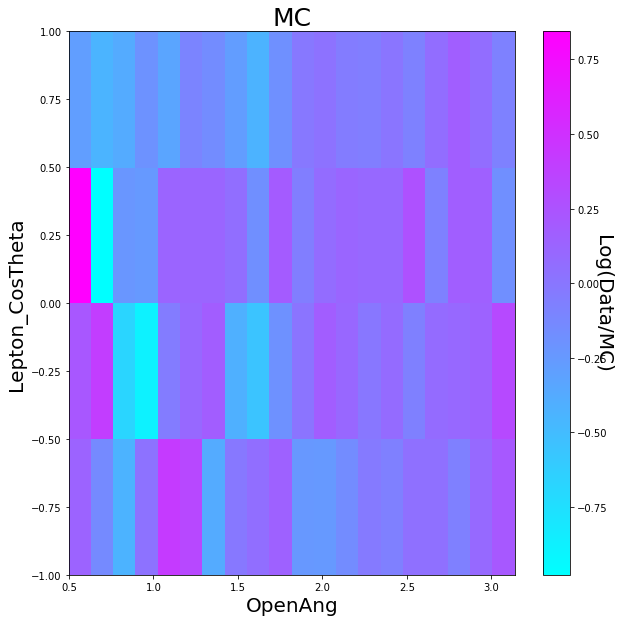

In [56]:
var1 = 'OpenAng'

nbins1 = 20
nbins2 = 4
range1 = (.5,np.pi)

fig,ax = plt.subplots(figsize=(10,10))

range2 = (-1,1)
var2 = 'Lepton_CosTheta'


    
ax.set_xlabel(var1,fontsize=20)
ax.set_ylabel(var2,fontsize=20)

vals_obs_var1,_,_,wgt_obs,scale_obs = run1DataHist.GetHist(var1)
vals_obs_var2,_,_,_,_ = run1DataHist.GetHist(var2)

Hobs, xedges, yedges = np.histogram2d(vals_obs_var1,vals_obs_var2,[nbins1,nbins2],[range1,range2],weights=wgt_obs*scale_obs)

a_vals_pred_var1,_,_,a_wgt_pred,a_scale_pred = run1Hists.GetHists(var1)
a_vals_pred_var2,_,_,_,_ = run1Hists.GetHists(var2)

vals_pred_var1 = np.concatenate(a_vals_pred_var1)
vals_pred_var2 = np.concatenate(a_vals_pred_var2)
wgt_pred = np.concatenate(a_wgt_pred)
scale_pred = np.concatenate(a_scale_pred)

Hpred,_,_ = np.histogram2d(vals_pred_var1,vals_pred_var2,[nbins1,nbins2],[range1,range2],weights=wgt_pred*scale_pred)

Hobs = Hobs.T
Hpred = Hpred.T
X, Y = np.meshgrid(xedges, yedges)

Hrat = np.true_divide(Hobs,Hpred)

#Hrat[Hrat>1000] = np.nan
#Hrat[Hrat<0] = .000001


crat = ax.pcolormesh(X, Y,np.log(Hrat),cmap='cool')#,vmin=-2,vmax=3)
#crat = ax.pcolormesh(X, Y,Hpred,cmap='cool')#,vmin=-2,vmax=3)

cbar = fig.colorbar(crat)
cbar.ax.set_ylabel('Log(Data/MC)', rotation=270,fontsize=20)
#cbar.ax.set_ylabel('Events', rotation=270,fontsize=20)

plt.title('MC',fontsize=25)
plt.xlim(range1)
plt.ylim(range2)

In [84]:
var1 = 'Enu_1m1p'
var2 = 'OpenAng'

nbins1 = 10
nbins2 = 10
range1 = (0,3000)
range2 = (0,3000)

df_sig = df_numu_presel.query("mc_label in ['nLmP','offvtx','badreco']")
df_bkg = df_numu_presel.query("mc_label in ['numu_CCQE']")

fig,ax = plt.subplots(figsize=(9,9))
ax.set_xlabel(var1,fontsize=20)
ax.set_ylabel(var2,fontsize=20)

Hsig, xedges, yedges = np.histogram2d(df_sig[var1],df_sig[var2],[nbins1,nbins2],[range1,range2],density=1)
Hbkg, _,_ = np.histogram2d(df_bkg[var1],df_bkg[var2],[nbins1,nbins2],[range1,range2],density=1)
Hsig = Hsig.T
Hbkg = Hbkg.T
X, Y = np.meshgrid(xedges, yedges)

Hrat = np.true_divide(Hsig,Hbkg)

Hrat[Hrat<1] = .000001

crat = ax.pcolormesh(X, Y, np.log10(Hrat),cmap='cool')
cbar = fig.colorbar(crat)
cbar.ax.set_ylabel('log(signal/background)', rotation=270,fontsize=10)

plt.xlim(range1)
plt.ylim(range2)
x0 = np.linspace(0,6)


y0 = -(x0)*300+250
y1 = (x0-2.6)*600



plt.plot(x0,y0,c='coral')
plt.plot(x0,y1,c='orange')
#ax.axvline(2.8)

NameError: name 'df_numu_presel' is not defined

In [ ]:
var1 = 'Thetas'
var2 = 'ChargeNearTrunk'

nbins1 = 20
nbins2 = 20
range1 = (0,3)
range2 = (0,1000)

df_sig = df_numu_CCQE_presel
df_bkg = df_bnb_offvtx_presel#df_ext_presel

fig,ax = plt.subplots(figsize=(9,9))
ax.set_xlabel(var1,fontsize=20)
ax.set_ylabel(var2,fontsize=20)

Hsig, xedges, yedges = np.histogram2d(df_sig[var1],df_sig[var2],[nbins1,nbins2],[range1,range2],weights=weights_numu_CCQE_presel,density=1)
Hbkg, _,_ = np.histogram2d(df_bkg[var1],df_bkg[var2],[nbins1,nbins2],[range1,range2],weights=weights_bnb_offvtx_presel,density=1)
Hsig = Hsig.T
Hbkg = Hbkg.T
X, Y = np.meshgrid(xedges, yedges)

Hrat = np.true_divide(Hsig,Hbkg)

Hrat[Hrat<1] = .000001

crat = ax.pcolormesh(X, Y, np.log10(Hrat),cmap='cool')
cbar = fig.colorbar(crat)
cbar.ax.set_ylabel('log(signal/background)', rotation=270,fontsize=10)

plt.xlim(range1)
plt.ylim(range2)
x0 = np.linspace(0,6)


y0 = -(x0)*300+250
y1 = (x0-2.6)*600



plt.plot(x0,y0,c='coral')
plt.plot(x0,y1,c='orange')
#ax.axvline(2.8)

In [ ]:
tag = 'Apr20-WiremodTest_run3'

orthogonalcut = 'MaxShrFrac < .2'
precuts ='OpenAng > .5 and ChargeNearTrunk > 0 and FailedBoost != 1 and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15'
emptycut = 'Enu_1m1p > 0'

precut = orthogonalcut + ' and ' + precuts

df_numu_presel = pd.read_parquet('../data/pickles/numu_goodruns_precuts_%s.parquet'%tag).query(precut)

In [ ]:
sampleHists = []
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['numu_CCQE']"),r'BNB $\nu_\mu$ CCQE','blue',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['numu_MEC']"),r'BNB $\nu_\mu$ MEC','cyan',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['numu_piplusminus']"),r'BNB $\nu_\mu$ Res $\pi^{+/-}$','darkgreen',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['numu_pizero']"),r'BNB $\nu_\mu$ Res $\pi^{0}$','greenyellow',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['numu_other','BNB nue_other','nue_MEC','nue_piplusminus','nue_pizero']"),r'BNB Other','gold',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['badreco']"),r'BNB Bad Reco','coral',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['offvtx']"),r'BNB 1L1P Off Vertex','grey',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['nLmP']"),r'BNB Not 1L1P','crimson',1,NUMU_SCALE))

In [ ]:
list(df_numu_presel)

In [ ]:
# distplot_wratio(string of variable name, number of bins, range, stacked histo list, data list, name for x-axis)
# for other arguments, see PlottingScripts.py

vartest = 'BDTscore_1mu1p_nu'
varname = vartest
myrange = (-10,10)
nbins =36

fig,ax0 = distplot_wratio(vartest,nbins,myrange,sampleHists,sampleHists[0],varname,normshift=.96)

In [ ]:
dfdirt1 = pd.read_parquet('../data/pickles/dirt_run1_nodupesMay1.parquet')
dfdirt2 = pd.read_parquet('../data/pickles/dirt_nodupes_Mar24-WC.parquet')
dfdirt3 = pd.read_parquet('../data/pickles/dirt_goodruns_precuts_Mar30-WC.parquet')

print(len(dfdirt1),len(dfdirt2),len(dfdirt3))